# Trading con Machine Learning: Classification

El mundo del trading financiero es un entorno **altamente competitivo y dinámico**, donde predecir los movimientos del mercado es un desafío constante incluso para los profesionales más experimentados. Con una sólida experiencia en el campo, me he propuesto llevar mi conocimiento al siguiente nivel aplicando técnicas de **Machine Learning (ML)** para mejorar estrategias de trading ya estadísticamente rentables.

## Hipótesis del Proyecto
¿Es posible potenciar una estrategia de trading rentable mediante la aplicación de modelos de clasificación de Machine Learning? Esta es la pregunta central que guía este proyecto. La hipótesis es que, al **identificar y aprender de patrones** presentes en operaciones exitosas, es posible filtrar operaciones con menor probabilidad de éxito y, por ende, mejorar el rendimiento general de la estrategia.

## Objetivo General
El objetivo principal es mejorar tres métricas clave de una estrategia de trading rentable mediante la aplicación de modelos de clasificación de ML:
- **Return [%]**: Aumentar el retorno porcentual de la inversión.
- **Max. Drawdown [%]**: Reducir el drawdown máximo, minimizando las pérdidas desde el pico hasta el valle más profundo.
- **Win Rate [%]**: Incrementar el porcentaje de operaciones ganadoras respecto al total de operaciones realizadas.

## Enfoques Metodológicos
Para abordar esta hipótesis, el proyecto se desarrolla en dos enfoques principales:
- **Aprendizaje de Patrones en Operaciones Ganadoras**: Investigar si existen patrones distintivos en las entradas ganadoras que el algoritmo pueda aprender. Esto permitiría filtrar operaciones con menor probabilidad de éxito, optimizando así la estrategia.
- **Mejora Sistemática mediante Características del Modelo**: Utilizar las características e insights proporcionados por los modelos de ML para identificar mejoras metodológicas en la estrategia de trading, aportando una base más sólida y analítica a las decisiones.

## Metodología del Proyecto
El desarrollo del proyecto sigue una secuencia estructurada de pasos:
1. **Recolección y Preprocesamiento de Datos**: Obtención de datos históricos relevantes y preparación de los mismos para garantizar su calidad y adecuación al análisis.
2. **Backtesting de la Estrategia Tradicional**: Ejecución de pruebas retrospectivas para evaluar el rendimiento de la estrategia de trading convencional y establecer una línea base.
3. **Ingeniería de Características**: Creación y selección de variables e indicadores que puedan aportar valor predictivo a los modelos de clasificación.
4. **Modelado y Evaluación**: Aplicación de modelos de clasificación de ML, ajustando y validando su desempeño para mejorar las métricas clave de la estrategia.
5. **Análisis de Resultados y Conclusiones**: Interpretación de los resultados obtenidos, evaluando el impacto de los modelos en la estrategia y extrayendo conclusiones sobre su viabilidad y efectividad.


1. Backtest
1.1 Carga y prepracion de datos
1.2 Logica de la estrategia y backtest
1.3 Analisis de resultados

2. Modelado
2.1. Preparacion de los datos (Backtest de largos y cortos separados, verificacion de datos)
2.2 Ingenieria de caracteristicas
2.3 Modelado y optimizacion

3. Resultados
4. 

## Recolección y Preprocesamiento de Datos:

# Preparación de Datos de Trading para Backtesting

Este código se encarga de cargar, filtrar y preparar datos históricos de trading de XAUUSD (velas de 1 minuto) desde archivos CSV. Posteriormente, se aplican cálculos de indicadores técnicos y se realizan pruebas para asegurar la integridad de los datos antes de su uso en backtesting.

### 1. Carga de Datos
Se leen múltiples archivos CSV (un total de 62 archivos) que contienen los datos históricos de XAUUSD desde el `2021-01-04` hasta el `2024-09-25`. Estos archivos se combinan en un único DataFrame, que luego se filtra por las siguientes fechas:
- **Entrenamiento**: desde el `2021-01-04` hasta el `2024-04-26`.
- **Prueba**: desde el `2024-04-29` hasta el `2024-09-25`.

### 2. Filtro por Sesiones de Mercado
Para limitar las operaciones a los horarios de mayor actividad, se filtran los datos para incluir únicamente las sesiones de **Londres** (5:00 - 10:00 UTC) y **Nueva York** (10:00 - 16:00 UTC). Esto permite un mejor control sobre el backtest y excluye periodos menos relevantes del día.

### 3. Cálculo de Indicadores Técnicos
Se calculan varios indicadores técnicos clave:
- **Media Móvil Exponencial (EMA)** de 70 y 250 periodos, utilizando el promedio de los valores OHLC (Open, High, Low, Close).
- **Índice de Fuerza Relativa (RSI)** de 8 periodos.

Estos indicadores son fundamentales para las reglas de la estrategia de trading aplicada en el backtest.

### 4. Pruebas de Integridad de Datos
Se realizaron varias pruebas para asegurar la integridad de los datos, incluyendo:
- **Detección de volúmenes igual a 0**: Esto verifica si existen registros donde el volumen de transacciones fue cero, lo cual podría indicar una vela vacía o sin actividad.
- **Eliminación de duplicados**: Se revisó si existen valores duplicados tras la concatenación de los diferentes archivos.
- **Otros chequeos**: Se llevaron a cabo verificaciones adicionales para garantizar que los datos estén listos para su uso en el backtest.

Finalmente, los datos se filtran y preparan tanto para el entrenamiento como para la prueba, asegurando que estén en el formato correcto para un análisis posterior.
is y backtest.


In [1]:
import os
import pandas as pd
import pandas_ta as ta

# Función para cargar y filtrar datos de TradingView
def cargar_datos_tradingview(folder_path, start_date, end_date):
    # Leer todos los archivos CSV y concatenarlos en un DataFrame
    df_concatenado = pd.concat(
        [pd.read_csv(os.path.join(folder_path, f))
         for f in sorted(os.listdir(folder_path)) if f.endswith('.csv')],
        ignore_index=True
    )

    # Convertir la columna 'time' a formato datetime
    df_concatenado['time'] = pd.to_datetime(df_concatenado['time'], unit='s')

    # Ordenar por la columna 'time' para asegurarse de que los tiempos están en orden
    df_concatenado = df_concatenado.sort_values(by='time').reset_index(drop=True)

    # Filtrar el DataFrame para el rango de fechas especificado
    df_filtrado = df_concatenado[(df_concatenado['time'] >= start_date) & (df_concatenado['time'] <= end_date)]
    
    return df_filtrado

# Función para aplicar el filtro basado en las horas de las sesiones usando siempre UTC
def filter_by_session_utc(df):
    # Asegurarse de trabajar con una copia del DataFrame
    df = df.copy()

    # Extraer la hora del día en formato 24h (en UTC)
    df['hour'] = df['time'].dt.hour

    # Definir las horas clave en UTC
    mask_london = (df['hour'] >= 5) & (df['hour'] < 10)
    mask_newyork = (df['hour'] >= 10) & (df['hour'] < 16)

    # Combinar todas las máscaras de las sesiones
    mask_sessions = mask_london | mask_newyork

    # Filtrar el DataFrame
    df_filtered = df[mask_sessions].drop(columns=['hour'])

    # Eliminar posibles duplicados que pueden surgir de cierres del mercado
    df_filtered = df_filtered.drop_duplicates(subset='time')
    
    return df_filtered

# Función para calcular los indicadores técnicos y preparar los datos para el backtest
def preparar_datos_para_backtest(df):
    dataf = df.copy()

    # Calcular los indicadores técnicos
    dataf['ohlc_avg'] = (dataf['open'] + dataf['high'] + dataf['low'] + dataf['close']) / 4
    dataf['EMA70'] = ta.ema(dataf['ohlc_avg'], length=70)
    dataf['EMA250'] = ta.ema(dataf['ohlc_avg'], length=250)
    dataf['RSI8'] = ta.rsi(dataf['ohlc_avg'], length=8)

    # Dropear los primeros 250 valores nulos por el cálculo de la EMA larga
    dataf = dataf.iloc[250:].reset_index(drop=True)

    # Renombrar las columnas para la biblioteca de backtesting
    dataf = dataf.rename(columns={
        'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close',
    })

    # Establecer la columna 'time' como índice
    dataf.set_index('time', inplace=True)

    return dataf

# Ruta a la carpeta de los archivos CSV
folder_path = r"C:\Users\Roger Saavedra\Desktop\ML VS BACKTEST\Data\XAUUSD 2021-2024 M1"

# Definir los rangos de fechas
# Para datos de entrenamiento
start_date_train = pd.to_datetime('2021-01-04')
end_date_train = pd.to_datetime('2024-04-26')

# Para datos de prueba
start_date_test = pd.to_datetime('2024-04-29')
end_date_test = pd.to_datetime('2024-09-25')

# Cargar, filtrar y preparar los datos de entrenamiento
df_entrenamiento = cargar_datos_tradingview(folder_path, start_date_train, end_date_train)
df_entrenamiento_filtrado = filter_by_session_utc(df_entrenamiento)
dataf_entrenamiento = preparar_datos_para_backtest(df_entrenamiento_filtrado)
print("Datos de Entrenamiento Preparados:")
print(dataf_entrenamiento)

# Cargar, filtrar y preparar los datos de prueba
df_prueba = cargar_datos_tradingview(folder_path, start_date_test, end_date_test)
df_prueba_filtrado = filter_by_session_utc(df_prueba)
dataf_prueba = preparar_datos_para_backtest(df_prueba_filtrado)
print("\nDatos de Prueba Preparados:")
print(dataf_prueba)


Datos de Entrenamiento Preparados:
                         Open      High       Low     Close  Volume  \
time                                                                  
2021-01-04 09:10:00  1933.251  1933.251  1932.785  1932.850      44   
2021-01-04 09:11:00  1932.850  1933.064  1932.731  1932.794      23   
2021-01-04 09:12:00  1932.794  1933.528  1932.707  1933.528      30   
2021-01-04 09:13:00  1933.528  1933.930  1932.528  1932.528      62   
2021-01-04 09:14:00  1932.528  1932.613  1931.457  1931.457      40   
...                       ...       ...       ...       ...     ...   
2024-04-25 15:55:00  2330.015  2330.300  2329.370  2329.905     251   
2024-04-25 15:56:00  2329.905  2331.120  2329.900  2330.610     250   
2024-04-25 15:57:00  2330.610  2330.615  2329.990  2330.010     233   
2024-04-25 15:58:00  2330.010  2330.615  2329.970  2330.085     228   
2024-04-25 15:59:00  2330.085  2330.975  2329.895  2330.440     236   

                       ohlc_avg        EM

### Eliminación de Períodos Anómalos en el Backtest

En este bloque de código, se eliminan rangos de fechas que representan **anomalías** en el backtest. Estos periodos están asociados a operaciones afectadas por **noticias de alto impacto** (noticias de impacto rojo), lo que genera trades con niveles de stop-loss (SL) inusualmente altos. Estas entradas no son deseadas porque:

- El **SL es muy amplio**, lo que afecta negativamente el riesgo asumido.
- Las operaciones pueden durar **días** para completarse, lo que aumenta la exposición al mercado durante periodos no operativos.
- No se desean trades que se mantengan **de un día para otro**, debido a los posibles **gaps** y **comisiones** adicionales.

Para solucionar esto, se implementa una función que elimina estos rangos específicos de tiempo tanto en los datos de **entrenamiento** como en los de **prueba**.

In [2]:
# Función para eliminar periodos en un DataFrame
def eliminar_periodos(df, periodos):
    for inicio, fin in periodos:
        df = df[~((df.index >= inicio) & (df.index <= fin))]
    return df

# Lista de periodos a eliminar
periodos_a_eliminar = [
    (pd.Timestamp('2022-04-19 15:55:00'), pd.Timestamp('2022-04-20 05:02:00')),
    (pd.Timestamp('2024-02-08 14:25:00'), pd.Timestamp('2024-02-08 14:45:00')),
    (pd.Timestamp('2024-01-18 13:24:00'), pd.Timestamp('2024-01-18 13:36:00')),
    (pd.Timestamp('2024-05-07 14:50:00'), pd.Timestamp('2024-05-07 15:10:00')),
    (pd.Timestamp('2024-07-05 12:20:00'), pd.Timestamp('2024-07-05 12:40:00'))
]

# Eliminar los periodos en los datos de entrenamiento
dataf_entrenamiento = eliminar_periodos(dataf_entrenamiento, periodos_a_eliminar)
print("Datos de Entrenamiento después de eliminar periodos:")
print(dataf_entrenamiento)

# Eliminar los periodos en los datos de prueba
dataf_prueba = eliminar_periodos(dataf_prueba, periodos_a_eliminar)
print("\nDatos de Prueba después de eliminar periodos:")
print(dataf_prueba)


Datos de Entrenamiento después de eliminar periodos:
                         Open      High       Low     Close  Volume  \
time                                                                  
2021-01-04 09:10:00  1933.251  1933.251  1932.785  1932.850      44   
2021-01-04 09:11:00  1932.850  1933.064  1932.731  1932.794      23   
2021-01-04 09:12:00  1932.794  1933.528  1932.707  1933.528      30   
2021-01-04 09:13:00  1933.528  1933.930  1932.528  1932.528      62   
2021-01-04 09:14:00  1932.528  1932.613  1931.457  1931.457      40   
...                       ...       ...       ...       ...     ...   
2024-04-25 15:55:00  2330.015  2330.300  2329.370  2329.905     251   
2024-04-25 15:56:00  2329.905  2331.120  2329.900  2330.610     250   
2024-04-25 15:57:00  2330.610  2330.615  2329.990  2330.010     233   
2024-04-25 15:58:00  2330.010  2330.615  2329.970  2330.085     228   
2024-04-25 15:59:00  2330.085  2330.975  2329.895  2330.440     236   

                       

# Estrategia EMARSIWithPipMarginStrategyCombined

Este bloque de código implementa una estrategia de trading que combina indicadores de **medias móviles exponenciales (EMA)** y el **Índice de Fuerza Relativa (RSI)**, con un margen fijo de 20 pips para gestionar el riesgo. La estrategia aplica diferentes lógicas para **operaciones largas (compra)** y **cortas (venta)**, utilizando cruces del RSI en niveles extremos (10 y 90) para definir las señales de entrada. A continuación, se detalla la lógica clave de la estrategia:

### Lógica de la Estrategia

1. **Detección de tendencia**:
   - **Largos (compra)**: Se considera una tendencia alcista cuando la EMA de 70 periodos (rápida) está por encima de la EMA de 250 periodos (lenta).
   - **Cortos (venta)**: Se considera una tendencia bajista cuando la EMA de 70 periodos está por debajo de la EMA de 250 periodos.

2. **Señales de compra (largos)**:
   - Se busca un cruce del RSI por debajo del nivel 10 (indicando una sobreventa).
   - Cuando el RSI vuelve a cruzar hacia arriba del nivel 10, se ejecuta la operación de compra.
   - El **stop-loss (SL)** se establece en el mínimo de las últimas 5 velas menos un margen de 20 pips.
   - El **take-profit (TP)** se calcula basado en un ratio riesgo/beneficio de 1:1.

3. **Señales de venta (cortos)**:
   - Se detecta un cruce del RSI por encima del nivel 90 (indicando una sobrecompra).
   - Cuando el RSI cruza hacia abajo del nivel 90, se ejecuta la operación de venta.
   - El **SL** se coloca en el máximo de las últimas 5 velas más un margen de 20 pips.
   - El **TP** se calcula también con un ratio riesgo/beneficio de 1:1.

4. **Zona de no operación**:
   - No se permiten operaciones en las últimas 30 velas antes del cierre de la sesión de Nueva York (15:30 - 16:00 UTC), para evitar operar en momentos de baja liquidez.

### Análisis de Backtest

Se realiza un primer backtest de la estrategia en dos periodos: **entrenamiento** y **prueba**, con el fin de evaluar su rendimiento en diferentes escenarios. Las métricas clave evaluadas incluyen:

- **Winrate**: El porcentaje de operaciones ganadoras sobre el total de operaciones.
- **Drawdown máximo (ddmax)**: La máxima caída desde el pico de la curva de equity, que mide el riesgo asumido.
- **Return final**: El retorno neto generado por la estrategia.
- **Trades ganadores y perdedores consecutivos**: La racha más larga de operaciones ganadoras y perdedoras, lo cual indica la consistencia de la estrategia.

Tras obtener los resultados del backtest, se decide dividir las operaciones en **largas** y **cortas** para entrenar dos modelos separados. Esta decisión se toma debido a las diferencias observadas en el comportamiento de la estrategia en mercados alcistas y bajistas, lo que podría mejorar el rendimiento general si se entrenan modelos especializados.

### Backtest Separado para Operaciones Largas y Cortas

Para mejorar la precisión de la estrategia, se implementan dos nuevos backtests:
- **Operaciones largas**: Solo se realizan operaciones de compra cuando las condiciones de tendencia alcista y cruce del RSI se cumplen.
- **Operaciones cortas**: Se entrenan modelos específicos para ventas, basándose en condiciones de tendencia bajista y cruces del RSI por encima de 90.

Este enfoque permite optimizar la estrategia al entrenar modelos independientes para cada tipo de operación, con la expectativa de mejorar las métricas de rendimiento, como el winrate y el drawdown, en cada escenario de mercado.


## Backtest dataf_entrenamiento completo

In [3]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista (largos)
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

# Función para validar si estamos en una tendencia bajista (cortos)
def is_bearish_trend(ema_fast, ema_slow):
    return ema_fast < ema_slow

class EMARSIWithPipMarginStrategyCombined(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # Riesgo fijo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variables para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra (largos)
        self.rsi_above_90 = False  # Para manejar las señales de venta (cortos)

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False

    def next(self):
        # Verificar si estamos dentro de la ventana de no operación
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]

        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

        ### Lógica de venta (cortos)
        if is_bearish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia arriba del nivel 90 del RSI (crossover)
            if crossover(self.rsi, 90) and not self.rsi_above_90:
                self.rsi_above_90 = True  # Marcamos que el RSI ha cruzado hacia arriba
            
            # Luego detectamos el cruce hacia abajo del nivel 90 (crossunder) después de haber cruzado hacia arriba
            if self.rsi_above_90 and crossunder(self.rsi, 90):
                sl = self.data.High[-5:].max() + (margen_pips * valor_pip)
                tp = self.data.Close[-1] - (sl - self.data.Close[-1]) * self.risk_reward_ratio
                
                risk_per_unit = sl - self.data.Close[-1]
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.sell(size=size, sl=sl, tp=tp)
                
                self.rsi_above_90 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest con la estrategia combinada
bt_entrenamiento = Backtest(dataf_entrenamiento, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_entrenamiento = bt_entrenamiento.run()
print(stats_entrenamiento)


C:\Users\Roger Saavedra\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Start                     2021-01-04 09:10:00
End                       2024-04-25 15:59:00
Duration                   1207 days 06:49:00
Exposure Time [%]                    2.367802
Equity Final [$]                    11190.232
Equity Peak [$]                     13428.025
Return [%]                           11.90232
Buy & Hold Return [%]               20.570143
Return (Ann.) [%]                    2.776974
Volatility (Ann.) [%]               18.778143
Sharpe Ratio                         0.147883
Sortino Ratio                        0.219433
Calmar Ratio                         0.134353
Max. Drawdown [%]                  -20.669309
Avg. Drawdown [%]                   -1.972645
Max. Drawdown Duration      399 days 00:14:00
Avg. Drawdown Duration       18 days 04:28:00
# Trades                                 1458
Win Rate [%]                        50.411523
Best Trade [%]                       0.436483
Worst Trade [%]                     -0.344177
Avg. Trade [%]                    

# En el siguiente bloque de codigo lo que busco es verificar graficamente que las entradas se ejecuten de la mejor manera

In [4]:
import warnings

# Ignorar todas las advertencias relacionadas con Bokeh y otras DeprecationWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Filtrar las últimas 10,000 filas del dataframe
filtered_data = dataf_entrenamiento.tail(10000)

# Ejecutar el backtest con los datos filtrados
bt_limited_entrenamiento = Backtest(filtered_data, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_limited_entrenamiento = bt_limited_entrenamiento.run()

# Graficar el backtest con las últimas 10,000 velas
bt_limited_entrenamiento.plot()


GridPlot(id='p1371', ...)

In [5]:
trades_entrenamiento = stats_entrenamiento['_trades']
equity_entrenamiento = stats_entrenamiento['_equity_curve']
trades_entrenamiento

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,76,80,84,1929.185,1930.487,98.952,0.000675,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00
1,135,221,222,1930.788,1931.526,99.630,0.000382,2021-01-04 12:51:00,2021-01-04 12:52:00,0 days 00:01:00
2,94,365,366,1933.622,1932.564,-99.452,-0.000547,2021-01-04 15:15:00,2021-01-04 15:16:00,0 days 00:01:00
3,21,370,389,1933.883,1938.550,98.007,0.002413,2021-01-04 15:20:00,2021-01-04 15:39:00,0 days 00:19:00
4,70,1465,1480,1951.007,1949.586,-99.470,-0.000728,2021-01-06 11:35:00,2021-01-06 11:50:00,0 days 00:15:00
...,...,...,...,...,...,...,...,...,...,...
1453,-40,562264,562279,2306.560,2309.035,-99.000,-0.001073,2024-04-23 12:10:00,2024-04-23 12:25:00,0 days 00:15:00
1454,-63,562958,562959,2321.710,2320.140,98.910,0.000676,2024-04-24 12:44:00,2024-04-24 12:45:00,0 days 00:01:00
1455,49,563157,563190,2316.400,2318.435,99.715,0.000879,2024-04-25 05:03:00,2024-04-25 05:36:00,0 days 00:33:00
1456,127,563593,563594,2326.290,2325.505,-99.695,-0.000337,2024-04-25 12:19:00,2024-04-25 12:20:00,0 days 00:01:00


In [6]:
trades_entrenamiento.describe()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458,1458,1458
mean,-5.032922,280559.625514,280567.781893,1876.793091,1876.828069,0.816346,0.000018,2022-08-26 23:43:05.185185024,2022-08-26 23:51:14.650205952,0 days 00:08:09.465020576
min,-487.000000,80.000000,84.000000,1624.550000,1623.705000,-100.000000,-0.003442,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:00:00
25%,-109.000000,137802.500000,137810.750000,1787.185000,1786.824750,-99.527000,-0.000497,2021-10-25 07:52:30,2021-10-25 08:00:45,0 days 00:02:00
50%,-24.500000,280832.000000,280837.500000,1856.021000,1856.147500,96.754000,0.000159,2022-08-26 06:35:00,2022-08-26 06:40:30,0 days 00:04:00
75%,101.000000,423083.500000,423089.750000,1953.085000,1952.300000,99.540000,0.000522,2023-06-28 19:20:30,2023-06-28 19:26:45,0 days 00:10:00
max,499.000000,563596.000000,563597.000000,2382.600000,2382.710000,100.000000,0.004365,2024-04-25 12:22:00,2024-04-25 12:23:00,0 days 02:29:00
std,132.507578,164428.046668,164428.630262,130.724168,130.733570,99.446045,0.000751,NaN,NaN,0 days 00:11:29.235888724


Máximo de trades ganadores consecutivos: 11
Máximo de trades perdedores consecutivos: 14


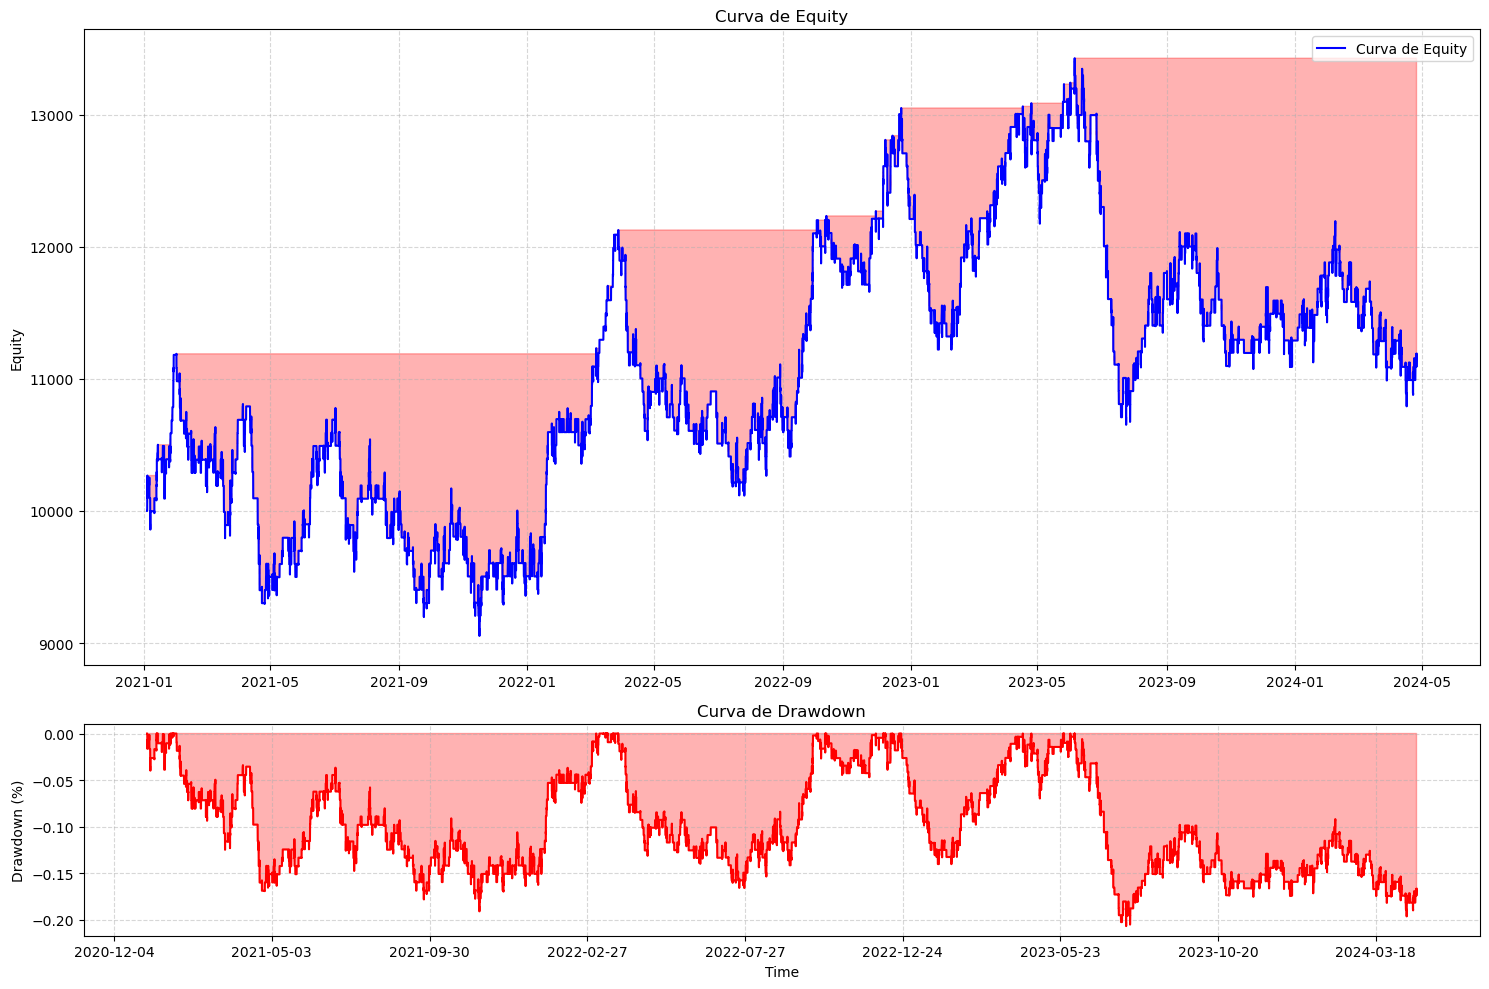

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Suponemos que 'PnL' es la columna que representa el beneficio o pérdida de cada trade
# Ganadores son aquellos con PnL positivo, perdedores con PnL negativo
trades_entrenamiento['is_winner'] = trades_entrenamiento['PnL'] > 0

# Identificar los cambios entre ganadores y perdedores para formar grupos
trades_entrenamiento['change'] = trades_entrenamiento['is_winner'].ne(trades_entrenamiento['is_winner'].shift()).cumsum()

# Calcular la longitud de cada grupo de trades ganadores o perdedores consecutivos
trades_grouped = trades_entrenamiento.groupby(['change', 'is_winner']).size()

# Obtener el número máximo de trades ganadores y perdedores consecutivos
max_win_streak = trades_grouped[trades_grouped.index.get_level_values('is_winner')].max()
max_loss_streak = trades_grouped[~trades_grouped.index.get_level_values('is_winner')].max()

trades_entrenamiento.drop(columns=['is_winner', 'change'], inplace=True)

print("Máximo de trades ganadores consecutivos:", max_win_streak)
print("Máximo de trades perdedores consecutivos:", max_loss_streak)


# Graficando equity haciendo enfassis en el DD

# Asumiendo que 'Equity' es la columna en equity_curve que contiene el valor de la equity a lo largo del tiempo
equity = equity_entrenamiento['Equity']

# Calcular el valor máximo acumulado en cada punto (curva de equity máxima)
max_equity = equity.cummax()

# Calcular el drawdown en porcentaje
drawdown = (equity - max_equity) / max_equity

# Graficar la curva de equity con el drawdown resaltado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Gráfico de la curva de equity
ax1.plot(equity_entrenamiento.index, equity, label='Curva de Equity', color='blue')
ax1.fill_between(equity_entrenamiento.index, equity, max_equity, where=(equity < max_equity), color='red', alpha=0.3)
ax1.set_title('Curva de Equity')
ax1.set_ylabel('Equity')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# Gráfico del drawdown en porcentaje
ax2.plot(equity_entrenamiento.index, drawdown, label='Drawdown', color='red')
ax2.fill_between(equity_entrenamiento.index, 0, drawdown, where=(drawdown < 0), color='red', alpha=0.3)
ax2.set_title('Curva de Drawdown')
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Time')
ax2.grid(True, linestyle='--', alpha=0.5)

# Ajustar los ticks del eje X para mostrar etiquetas más específicas si es necesario
ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))  # Ajusta a la cantidad deseada de ticks

plt.tight_layout()
plt.show()


## Conclusiones de la Estrategia

### Número promedio de operaciones diarias:
La estrategia genera aproximadamente **1.2 operaciones diarias**. Aunque es una cifra moderada para una estrategia basada en velas de 1 minuto, proporciona una cantidad suficiente de operaciones para evaluar la efectividad del sistema sin sobreexponer al trader.

### Win Rate [%]: 50.41%
Con una tasa de aciertos apenas superior al **50%** y un ratio riesgo/beneficio de 1:1, la estrategia se muestra marginalmente rentable. Sin embargo, dado que el backtest se realizó **sin considerar comisiones**, es probable que los costos asociados a las operaciones hagan que la estrategia sea menos rentable o incluso perdedora en escenarios reales.

### Return [%]: 11.90%
El retorno total obtenido del **11.90%** durante el periodo de prueba es significativamente inferior al retorno del **Buy & Hold** del mismo activo, lo que indica que la estrategia no maximiza las oportunidades de ganancia en comparación con una estrategia pasiva a largo plazo.

### Max. Drawdown [%]: -20.67%
Un drawdown máximo del **20.67%** es elevado, especialmente considerando que la estrategia arriesga solo un **1% del capital** por operación. Este nivel de drawdown puede ser difícil de gestionar para algunos traders, ya que implica una recuperación prolongada y un riesgo elevado de pérdida.

### Rachas de operaciones:

- **Máximo de trades ganadores consecutivos**: 11  
- **Máximo de trades perdedores consecutivos**: 14  

La racha de operaciones perdedoras es más prolongada que la de ganadoras, lo que podría afectar la confianza del trader y exigir un mayor control emocional. Perder **14 operaciones seguidas** podría llevar a una crisis de confianza en la estrategia si no se cuenta con un plan de gestión del riesgo adecuado.

### Duración promedio de las operaciones:
Las operaciones duran, en promedio, **9 minutos**, lo que permite un ritmo relativamente rápido de entradas y salidas, adecuado para traders intradía que buscan capturar movimientos rápidos del mercado.

---

## Validación de Datos

### Integridad y consistencia de los datos
Se graficaron las últimas **10,000 velas** para validar visualmente que la estrategia sigue correctamente las reglas predefinidas. Los datos no presentan anomalías ni inconsistencias en su ejecución, lo que confirma la fiabilidad de los resultados obtenidos en el backtest.

### Comparación con TradingView
La estrategia fue replicada en **TradingView** para validar los resultados del backtest, asegurando que las señales de entrada y salida sean consistentes con la lógica implementada. Esta doble validación es fundamental para garantizar la precisión del análisis y confirmar que la estrategia se comporta de manera coherente en diferentes plataformas.

### Verificación gráfica
Además, se graficaron las últimas **10,000 velas** para verificar que la lógica de la estrategia se cumple a la perfección, confirmando visualmente la ejecución correcta de las señales de entrada y salida según los parámetros establecidos.

---

## Conclusiones Generales

### Rentabilidad estadística:
Aunque la estrategia ha mostrado ser **estadísticamente rentable**, con un retorno positivo y un win rate ligeramente superior al **50%**, los resultados no son óptimos. Existe un amplio margen para mejorar el sistema, especialmente en la gestión del riesgo y la reducción del drawdown.

### Próximos pasos:
El siguiente paso será **optimizar la estrategia utilizando algoritmos de Machine Learning** para mejorar la toma de decisiones en las operaciones y ajustar las reglas de entrada y salida con base en patrones más avanzados. Esto podría potenciar la rentabilidad y reducir la exposición al riesgo.


## Backtest dataf_prueba

In [8]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista (largos)
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

# Función para validar si estamos en una tendencia bajista (cortos)
def is_bearish_trend(ema_fast, ema_slow):
    return ema_fast < ema_slow

class EMARSIWithPipMarginStrategyCombined(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # Riesgo fijo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variables para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra (largos)
        self.rsi_above_90 = False  # Para manejar las señales de venta (cortos)

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False

    def next(self):
        # Verificar si estamos dentro de la ventana de no operación
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]

        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

        ### Lógica de venta (cortos)
        if is_bearish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia arriba del nivel 90 del RSI (crossover)
            if crossover(self.rsi, 90) and not self.rsi_above_90:
                self.rsi_above_90 = True  # Marcamos que el RSI ha cruzado hacia arriba
            
            # Luego detectamos el cruce hacia abajo del nivel 90 (crossunder) después de haber cruzado hacia arriba
            if self.rsi_above_90 and crossunder(self.rsi, 90):
                sl = self.data.High[-5:].max() + (margen_pips * valor_pip)
                tp = self.data.Close[-1] - (sl - self.data.Close[-1]) * self.risk_reward_ratio
                
                risk_per_unit = sl - self.data.Close[-1]
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.sell(size=size, sl=sl, tp=tp)
                
                self.rsi_above_90 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest con la estrategia combinada
bt_prueba = Backtest(dataf_prueba, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_prueba = bt_prueba.run()
print(stats_prueba)


Start                     2024-04-29 09:10:00
End                       2024-09-24 15:59:00
Duration                    148 days 06:49:00
Exposure Time [%]                    2.067455
Equity Final [$]                      6193.69
Equity Peak [$]                      10020.37
Return [%]                           -38.0631
Buy & Hold Return [%]               13.004694
Return (Ann.) [%]                  -66.070616
Volatility (Ann.) [%]                8.638964
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -38.189009
Avg. Drawdown [%]                  -38.189009
Max. Drawdown Duration      148 days 04:13:00
Avg. Drawdown Duration      148 days 04:13:00
# Trades                                  175
Win Rate [%]                        38.857143
Best Trade [%]                       0.260238
Worst Trade [%]                      -0.22381
Avg. Trade [%]                    

In [9]:
trades_prueba = stats_prueba['_trades']
equity_prueba = stats_prueba['_equity_curve']
trades_prueba

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,97,156,159,2339.165,2338.140,-99.425,-0.000438,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:03:00
1,68,168,184,2336.715,2335.250,-99.620,-0.000627,2024-04-29 11:58:00,2024-04-29 12:14:00,0 days 00:16:00
2,-56,935,936,2310.045,2311.805,-98.560,-0.000762,2024-04-30 13:45:00,2024-04-30 13:46:00,0 days 00:01:00
3,-77,1323,1329,2288.340,2287.050,99.330,0.000564,2024-05-01 09:13:00,2024-05-01 09:19:00,0 days 00:06:00
4,-109,1366,1367,2291.820,2292.735,-99.735,-0.000399,2024-05-01 09:56:00,2024-05-01 09:57:00,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...
170,100,69151,69151,2618.545,2619.610,106.500,0.000407,2024-09-23 07:23:00,2024-09-23 07:23:00,0 days 00:00:00
171,-217,69305,69308,2621.745,2621.295,97.650,0.000172,2024-09-23 09:57:00,2024-09-23 10:00:00,0 days 00:03:00
172,42,69716,69724,2631.705,2629.420,-95.970,-0.000868,2024-09-24 05:48:00,2024-09-24 05:56:00,0 days 00:08:00
173,28,69730,69827,2627.765,2624.400,-94.220,-0.001281,2024-09-24 06:02:00,2024-09-24 07:39:00,0 days 01:37:00


In [10]:
trades_prueba.describe()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175,175,175
mean,1.977143,36695.988571,36703.297143,2414.905914,2414.588457,-21.750343,-0.000073,2024-07-15 11:25:26.057142784,2024-07-15 11:32:44.571428608,0 days 00:07:18.514285714
min,-259.000000,156.000000,159.000000,2288.340000,2287.050000,-110.760000,-0.002238,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:00:00
25%,-79.500000,21197.000000,21211.500000,2333.057500,2332.867500,-99.515000,-0.000530,2024-06-12 10:48:00,2024-06-12 11:02:30,0 days 00:01:00
50%,28.000000,36183.000000,36183.000000,2394.890000,2393.465000,-96.965000,-0.000278,2024-07-15 07:55:00,2024-07-15 07:55:00,0 days 00:03:00
75%,82.000000,56431.000000,56435.500000,2499.972500,2499.497500,98.840000,0.000433,2024-08-26 21:53:00,2024-08-26 21:57:30,0 days 00:08:00
max,208.000000,70039.000000,70063.000000,2631.705000,2629.420000,113.400000,0.002602,2024-09-24 11:11:00,2024-09-24 11:35:00,0 days 01:37:00
std,107.401115,20278.956809,20278.950982,90.532310,90.501529,97.379908,0.000771,NaN,NaN,0 days 00:12:36.671529103


Máximo de trades ganadores consecutivos: 7
Máximo de trades perdedores consecutivos: 9


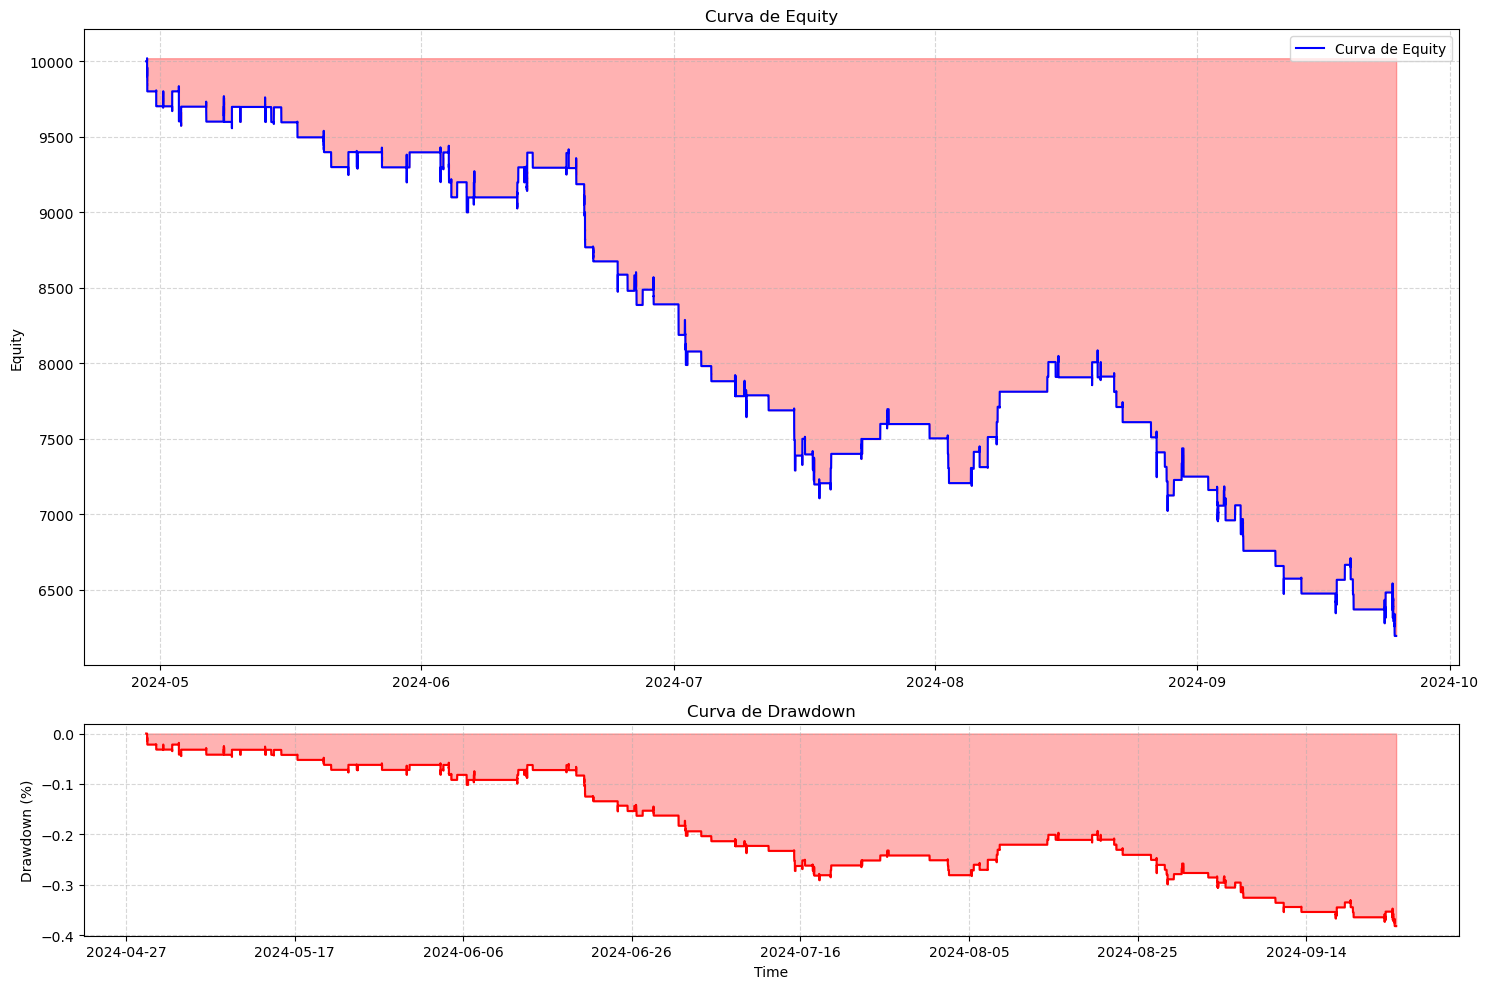

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Suponemos que 'PnL' es la columna que representa el beneficio o pérdida de cada trade
# Ganadores son aquellos con PnL positivo, perdedores con PnL negativo
trades_prueba['is_winner'] = trades_prueba['PnL'] > 0

# Identificar los cambios entre ganadores y perdedores para formar grupos
trades_prueba['change'] = trades_prueba['is_winner'].ne(trades_prueba['is_winner'].shift()).cumsum()

# Calcular la longitud de cada grupo de trades ganadores o perdedores consecutivos
trades_grouped = trades_prueba.groupby(['change', 'is_winner']).size()

# Obtener el número máximo de trades ganadores y perdedores consecutivos
max_win_streak = trades_grouped[trades_grouped.index.get_level_values('is_winner')].max()
max_loss_streak = trades_grouped[~trades_grouped.index.get_level_values('is_winner')].max()

# Limpiar las columnas temporales
trades_prueba.drop(columns=['is_winner', 'change'], inplace=True)

print("Máximo de trades ganadores consecutivos:", max_win_streak)
print("Máximo de trades perdedores consecutivos:", max_loss_streak)

# Graficando la curva de equity con énfasis en el drawdown

# Asumiendo que 'Equity' es la columna en equity_prueba que contiene el valor de la equity a lo largo del tiempo
equity = equity_prueba['Equity']

# Calcular el valor máximo acumulado en cada punto (curva de equity máxima)
max_equity = equity.cummax()

# Calcular el drawdown en porcentaje
drawdown = (equity - max_equity) / max_equity

# Graficar la curva de equity con el drawdown resaltado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Gráfico de la curva de equity
ax1.plot(equity_prueba.index, equity, label='Curva de Equity', color='blue')
ax1.fill_between(equity_prueba.index, equity, max_equity, where=(equity < max_equity), color='red', alpha=0.3)
ax1.set_title('Curva de Equity')
ax1.set_ylabel('Equity')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# Gráfico del drawdown en porcentaje
ax2.plot(equity_prueba.index, drawdown, label='Drawdown', color='red')
ax2.fill_between(equity_prueba.index, 0, drawdown, where=(drawdown < 0), color='red', alpha=0.3)
ax2.set_title('Curva de Drawdown')
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Time')
ax2.grid(True, linestyle='--', alpha=0.5)

# Ajustar los ticks del eje X para mostrar etiquetas más específicas si es necesario
ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))  # Ajusta a la cantidad deseada de ticks

plt.tight_layout()
plt.show()


## Conclusiones del Análisis de la Estrategia EMARSIWithPipMarginStrategyCombined (Período de Prueba)

Durante el período de backtest comprendido entre el **29 de abril de 2024** y el **24 de septiembre de 2024**, la estrategia mostró un desempeño negativo. Este rendimiento será comparado con los modelos entrenados con **Machine Learning** para evaluar si se alcanzan los objetivos del proyecto.

### Desempeño General
- **Retorno Total [%]**: -38.06%, en contraste con el **13.00%** del Buy & Hold, lo que indica un rendimiento significativamente desfavorable.
- **Equidad Final [$]**: El capital inicial disminuyó a **$6,193.69**, desde un pico de **$10,020.37**.
- **Duración del Drawdown**: El drawdown persistió durante **148 días**, sin ninguna recuperación notable.

### Rendimiento de las Operaciones
- **Número Total de Operaciones**: Se realizaron **175 operaciones**, con un promedio de **1.18 operaciones por día**.
- **Win Rate [%]**: **38.86%**, lo que implica que solo **4 de cada 10 operaciones** fueron exitosas.

### Observaciones Clave
- **Deterioro de la estrategia**: Desde junio de 2023, la estrategia experimentó un drawdown profundo y sostenido, lo que sugiere una falta de adaptación a las condiciones cambiantes del mercado.
- **Ineficacia de las señales**: El bajo win rate y la expectativa negativa por operación indican que las señales de entrada y salida no fueron eficaces, afectando negativamente el rendimiento global.

### Conclusión General
Los resultados del período de prueba evidencian un **desempeño no rentable**. La estrategia **EMARSIWithPipMarginStrategyCombined** no logró adaptarse a las dinámicas del mercado, mostrando debilidades significativas que resultaron en una pérdida considerable de capital.

Como respuesta, se ha decidido separar las operaciones **largas** y **cortas** para entrenar modelos con **algoritmos de Machine Learning**, con el objetivo de optimizar el rendimiento y cumplir con los objetivos del proyecto.


# MODELADO

## Modelo Largos

### Iniciamos con el backtest unicamente de operaciones largas

In [12]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

class EMARSIWithPipMarginStrategyLong(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # con 5% de riesgo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variable para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False
          
    def next(self):
        # Verificar si estamos dentro de la ventana de no operación (10 velas antes del cierre)
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]
        
        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest para largos
bt_longs = Backtest(dataf_entrenamiento, EMARSIWithPipMarginStrategyLong, cash=10000, margin=1/10000, commission=.000)
stats_longs = bt_longs.run()
print(stats_longs)


Start                     2021-01-04 09:10:00
End                       2024-04-25 15:59:00
Duration                   1207 days 06:49:00
Exposure Time [%]                    1.198977
Equity Final [$]                    11793.598
Equity Peak [$]                     12236.098
Return [%]                           17.93598
Buy & Hold Return [%]               20.570143
Return (Ann.) [%]                     4.38016
Volatility (Ann.) [%]               15.133701
Sharpe Ratio                         0.289431
Sortino Ratio                        0.439001
Calmar Ratio                         0.196492
Max. Drawdown [%]                  -22.291816
Avg. Drawdown [%]                   -1.797027
Max. Drawdown Duration      687 days 00:54:00
Avg. Drawdown Duration       25 days 07:50:00
# Trades                                  724
Win Rate [%]                        51.243094
Best Trade [%]                       0.436483
Worst Trade [%]                     -0.344177
Avg. Trade [%]                    

In [13]:
trades_longs = stats_longs['_trades']
trades_longs.describe()


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724,724,724
mean,112.418508,275520.723757,275529.060773,1884.070413,1884.142155,2.477345,0.000037,2022-08-16 04:29:13.674033152,2022-08-16 04:37:33.977900544,0 days 00:08:20.303867403
min,11.000000,80.000000,84.000000,1643.280000,1642.515000,-100.000000,-0.003442,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:00:00
25%,66.000000,136551.250000,136554.500000,1789.117500,1788.750000,-99.459500,-0.000516,2021-10-21 05:46:15,2021-10-21 05:49:30,0 days 00:02:00
50%,101.000000,266879.000000,266899.000000,1856.787500,1858.122500,97.560000,0.000211,2022-07-27 22:32:00,2022-07-27 22:52:00,0 days 00:04:00
75%,145.000000,417515.250000,417516.750000,1958.827500,1958.658750,99.540000,0.000532,2023-06-16 13:32:15,2023-06-16 13:33:45,0 days 00:10:00
max,499.000000,563596.000000,563597.000000,2382.600000,2381.495000,100.000000,0.004365,2024-04-25 12:22:00,2024-04-25 12:23:00,0 days 02:29:00
std,61.707764,165386.217115,165387.244657,135.494340,135.528801,99.409018,0.000798,NaN,NaN,0 days 00:12:11.975418067


In [29]:
# Filtrar las operaciones que NO estén en el rango de -120 a 120
anomalous_trades = trades_longs[(trades_longs['PnL'] < -120) | (trades_longs['PnL'] > 120)]
#anomalous_trades

# Filtrar las operaciones que duren más de 3 horas
trades_longs['Duration'] = pd.to_timedelta(trades_longs['Duration'])  # Asegurarse de que la columna Duration esté en formato timedelta
long_duration_trades = trades_longs[trades_longs['Duration'] > pd.Timedelta(hours=3)]
#long_duration_trades 


In [14]:
# Dropeo las columnas que no voy a utilizar
trades_longs = trades_longs.drop(columns = ['Size','EntryBar','ExitBar','ReturnPct'])

#Creo la variable objetivo 
trades_longs['result'] = trades_longs['PnL'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else np.nan)).astype('Int64')

#El backtest se realiza entrando en el opening de la vela que dio la senal por lo cual nuestras condiciones es una vela antes por esto hago el ajuste
trades_longs['AdjustedEntryTime'] = trades_longs['EntryTime'] - pd.Timedelta(minutes=1)

trades_longs




,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,AdjustedEntryTime
0,1929.185,1930.487,98.952,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00,1,2021-01-04 10:29:00
1,1930.788,1931.526,99.630,2021-01-04 12:51:00,2021-01-04 12:52:00,0 days 00:01:00,1,2021-01-04 12:50:00
2,1933.622,1932.564,-99.452,2021-01-04 15:15:00,2021-01-04 15:16:00,0 days 00:01:00,0,2021-01-04 15:14:00
3,1933.883,1938.550,98.007,2021-01-04 15:20:00,2021-01-04 15:39:00,0 days 00:19:00,1,2021-01-04 15:19:00
4,1951.007,1949.586,-99.470,2021-01-06 11:35:00,2021-01-06 11:50:00,0 days 00:15:00,0,2021-01-06 11:34:00
...,...,...,...,...,...,...,...,...
719,2382.600,2379.520,-98.560,2024-04-19 08:13:00,2024-04-19 08:27:00,0 days 00:14:00,0,2024-04-19 08:12:00
720,2369.105,2367.555,-99.200,2024-04-22 05:09:00,2024-04-22 05:36:00,0 days 00:27:00,0,2024-04-22 05:08:00
721,2316.400,2318.435,99.715,2024-04-25 05:03:00,2024-04-25 05:36:00,0 days 00:33:00,1,2024-04-25 05:02:00
722,2326.290,2325.505,-99.695,2024-04-25 12:19:00,2024-04-25 12:20:00,0 days 00:01:00,0,2024-04-25 12:18:00


In [22]:
import numpy as np
import pandas as pd
import pandas_ta as ta

def calc_price_features(df):
    df['perc_var_open_close'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    df['candle_range_perc'] = ((df['High'] - df['Low']) / df['Open']) * 100
    df['body_size_perc'] = (abs(df['Close'] - df['Open']) / df['Open']) * 100
    df['upper_shadow_perc'] = ((df['High'] - df[['Open', 'Close']].max(axis=1)) / df['Open']) * 100
    df['lower_shadow_perc'] = ((df[['Open', 'Close']].min(axis=1) - df['Low']) / df['Open']) * 100
    df['upper_shadow_ratio'] = df['upper_shadow_perc'] / df['candle_range_perc']
    df['lower_shadow_ratio'] = df['lower_shadow_perc'] / df['candle_range_perc']
    df['body_to_range_ratio'] = df['body_size_perc'] / df['candle_range_perc']
    return df

def calc_window_stats(df, window):
    df[f'perc_var_open_close_mean_{window}'] = df['perc_var_open_close'].rolling(window).mean()
    df[f'perc_var_open_close_std_{window}'] = df['perc_var_open_close'].rolling(window).std()
    df[f'perc_var_open_close_min_{window}'] = df['perc_var_open_close'].rolling(window).min()
    df[f'perc_var_open_close_max_{window}'] = df['perc_var_open_close'].rolling(window).max()
    df[f'perc_var_open_close_median_{window}'] = df['perc_var_open_close'].rolling(window).median()
    
    df[f'candle_range_perc_mean_{window}'] = df['candle_range_perc'].rolling(window).mean()
    df[f'candle_range_perc_std_{window}'] = df['candle_range_perc'].rolling(window).std()
    df[f'candle_range_perc_min_{window}'] = df['candle_range_perc'].rolling(window).min()
    df[f'candle_range_perc_max_{window}'] = df['candle_range_perc'].rolling(window).max()
    df[f'candle_range_perc_median_{window}'] = df['candle_range_perc'].rolling(window).median()
    
    df[f'upper_shadow_ratio_mean_{window}'] = df['upper_shadow_ratio'].rolling(window).mean()
    df[f'upper_shadow_ratio_std_{window}'] = df['upper_shadow_ratio'].rolling(window).std()
    df[f'lower_shadow_ratio_mean_{window}'] = df['lower_shadow_ratio'].rolling(window).mean()
    df[f'lower_shadow_ratio_std_{window}'] = df['lower_shadow_ratio'].rolling(window).std()
    df[f'body_to_range_ratio_mean_{window}'] = df['body_to_range_ratio'].rolling(window).mean()
    df[f'body_to_range_ratio_std_{window}'] = df['body_to_range_ratio'].rolling(window).std()
    
    return df

def calc_rsi_features(df, window):
    df[f'RSI8_mean_{window}'] = df['RSI8'].rolling(window).mean()
    df[f'RSI8_std_{window}'] = df['RSI8'].rolling(window).std()
    df[f'RSI8_min_{window}'] = df['RSI8'].rolling(window).min()
    df[f'RSI8_25%_{window}'] = df['RSI8'].rolling(window).quantile(0.25)
    df[f'RSI8_50%_{window}'] = df['RSI8'].rolling(window).quantile(0.50)
    df[f'RSI8_75%_{window}'] = df['RSI8'].rolling(window).quantile(0.75)
    df[f'RSI8_max_{window}'] = df['RSI8'].rolling(window).max()
    df['RSI8_slope_5'] = (df['RSI8'] - df['RSI8'].shift(3)) / 3
    return df

def calc_ema_features(df, window):
    df[f'EMA70_mean_{window}'] = df['EMA70'].rolling(window).mean()
    df[f'EMA70_std_{window}'] = df['EMA70'].rolling(window).std()
    df[f'EMA70_min_{window}'] = df['EMA70'].rolling(window).min()
    df[f'EMA70_max_{window}'] = df['EMA70'].rolling(window).max()
    df[f'EMA70_median_{window}'] = df['EMA70'].rolling(window).median()
    
    df[f'EMA250_mean_{window}'] = df['EMA250'].rolling(window).mean()
    df[f'EMA250_std_{window}'] = df['EMA250'].rolling(window).std()
    df[f'EMA250_min_{window}'] = df['EMA250'].rolling(window).min()
    df[f'EMA250_max_{window}'] = df['EMA250'].rolling(window).max()
    df[f'EMA250_median_{window}'] = df['EMA250'].rolling(window).median()
    
    df['ema_diff'] = df['EMA70'] - df['EMA250']
    df[f'ema_diff_mean_{window}'] = df['ema_diff'].rolling(window).mean()
    df[f'ema_diff_std_{window}'] = df['ema_diff'].rolling(window).std()
    df[f'ema_diff_min_{window}'] = df['ema_diff'].rolling(window).min()
    df[f'ema_diff_max_{window}'] = df['ema_diff'].rolling(window).max()
    df[f'ema_diff_median_{window}'] = df['ema_diff'].rolling(window).median()
    
    df['close_to_ema70'] = df['Close'] - df['EMA70']
    df['close_to_ema250'] = df['Close'] - df['EMA250']
    df[f'close_to_ema70_mean_{window}'] = df['close_to_ema70'].rolling(window).mean()
    df[f'close_to_ema70_std_{window}'] = df['close_to_ema70'].rolling(window).std()
    df[f'close_to_ema250_mean_{window}'] = df['close_to_ema250'].rolling(window).mean()
    df[f'close_to_ema250_std_{window}'] = df['close_to_ema250'].rolling(window).std()
    
    df['EMA_ratio'] = df['EMA70'] / df['EMA250']
    df[f'EMA_ratio_mean_{window}'] = df['EMA_ratio'].rolling(window).mean()
    df[f'EMA_ratio_std_{window}'] = df['EMA_ratio'].rolling(window).std()
    
    df['EMA70_slope_5'] = (df['EMA70'] - df['EMA70'].shift(3)) / 3
    df['EMA250_slope_5'] = (df['EMA250'] - df['EMA250'].shift(3)) / 3
    df['ema_diff_slope_5'] = (df['ema_diff'] - df['ema_diff'].shift(3)) / 3
    return df

def calc_volatility_atr(df, window):
    df['atr_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df[f'atr_14_mean_{window}'] = df['atr_14'].rolling(window).mean()
    df[f'atr_14_std_{window}'] = df['atr_14'].rolling(window).std()
    df[f'atr_14_min_{window}'] = df['atr_14'].rolling(window).min()
    df[f'atr_14_max_{window}'] = df['atr_14'].rolling(window).max()
    df[f'atr_14_median_{window}'] = df['atr_14'].rolling(window).median()
    
    df['atr_14_slope_5'] = (df['atr_14'] - df['atr_14'].shift(3)) / 3
    return df

def calc_volume_features(df, window):
    df[f'Volume_mean_{window}'] = df['Volume'].rolling(window).mean()
    df[f'Volume_std_{window}'] = df['Volume'].rolling(window).std()
    df[f'Volume_min_{window}'] = df['Volume'].rolling(window).min()
    df[f'Volume_max_{window}'] = df['Volume'].rolling(window).max()
    df[f'Volume_median_{window}'] = df['Volume'].rolling(window).median()
    
    df[f'Volume_relative_{window}'] = df['Volume'] / df[f'Volume_mean_{window}']
    return df

def calc_obv_features(df, window):
    df['obv'] = ta.obv(df['Close'], df['Volume'])
    df[f'obv_mean_{window}'] = df['obv'].rolling(window).mean()
    df[f'obv_std_{window}'] = df['obv'].rolling(window).std()  
    df[f'obv_slope_{window}'] = (df['obv'] - df['obv'].shift(window)) / window
    return df

def calc_cmf_features(df, window):
    df['cmf_20'] = ta.cmf(df['High'], df['Low'], df['Close'], df['Volume'], length=20)
    df[f'cmf_mean_{window}'] = df['cmf_20'].rolling(window).mean()
    df[f'cmf_std_{window}'] = df['cmf_20'].rolling(window).std()
    df[f'cmf_slope_{window}'] = (df['cmf_20'] - df['cmf_20'].shift(window)) / window
    return df

def calc_return_volatility_features(df, window):
    # Crear las nuevas columnas directamente en el dataframe
    df['volatility_14'] = df['Close'].pct_change().rolling(window=14).std()
    df['return_5'] = df['Close'].pct_change(3)
    df['risk_adjusted_return_5'] = df['return_5'] / df['volatility_14'].replace(0, np.nan)
    df['rsi_volatility_ratio'] = df['RSI8'] / df['atr_14'].replace(0, np.nan)

    # Estadísticas sobre volatilidad, retornos y riesgo ajustado
    df[f'volatility_14_mean_{window}'] = df['volatility_14'].rolling(window).mean()
    df[f'volatility_14_std_{window}'] = df['volatility_14'].rolling(window).std()
    df[f'volatility_14_min_{window}'] = df['volatility_14'].rolling(window).min()
    df[f'volatility_14_max_{window}'] = df['volatility_14'].rolling(window).max()
    df[f'volatility_14_median_{window}'] = df['volatility_14'].rolling(window).median()
    df[f'volatility_14_slope_{window}'] = (df['volatility_14'] - df['volatility_14'].shift(window)) / window

    df[f'return_5_mean_{window}'] = df['return_5'].rolling(window).mean()
    df[f'return_5_std_{window}'] = df['return_5'].rolling(window).std()
    
    df[f'risk_adjusted_return_5_mean_{window}'] = df['risk_adjusted_return_5'].rolling(window).mean()
    df[f'risk_adjusted_return_5_std_{window}'] = df['risk_adjusted_return_5'].rolling(window).std()

    df[f'rsi_volatility_ratio_mean_{window}'] = df['rsi_volatility_ratio'].rolling(window).mean()
    df[f'rsi_volatility_ratio_std_{window}'] = df['rsi_volatility_ratio'].rolling(window).std()
    df[f'rsi_volatility_ratio_min_{window}'] = df['rsi_volatility_ratio'].rolling(window).min()
    df[f'rsi_volatility_ratio_max_{window}'] = df['rsi_volatility_ratio'].rolling(window).max()
    df[f'rsi_volatility_ratio_median_{window}'] = df['rsi_volatility_ratio'].rolling(window).median()
    df[f'rsi_volatility_ratio_slope_{window}'] = (df['rsi_volatility_ratio'] - df['rsi_volatility_ratio'].shift(window)) / window

    return df

# Función principal para calcular todas las características
def calculate_all_features(df):
    df = calc_price_features(df)
    df = calc_window_stats(df, window=3)
    df = calc_rsi_features(df, window=3)
    df = calc_ema_features(df, window=3)
    df = calc_volatility_atr(df, window=3)
    df = calc_volume_features(df, window=3)
    df = calc_obv_features(df, window=3)
    df = calc_cmf_features(df, window=3)
    df = calc_return_volatility_features(df, window=3)

    # Eliminar filas con valores NaN generados por los cálculos
    df.dropna(inplace=True)

    return df

# Usar la función para calcular todas las características
df_entrenamiento_largos = calculate_all_features(dataf_entrenamiento)
df_entrenamiento_largos


,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:16:00,1931.440,1931.536,1931.152,1931.192,30,1931.33000,1931.919918,1928.124665,36.390749,-0.012840,0.019882,0.012840,0.004970,0.002071,0.250000,0.104167,0.645833,-0.019685,0.017664,-0.039747,-0.006469,-0.012840,0.024448,0.013604,0.013714,0.039747,0.019882,0.205346,0.187060,0.088810,0.082215,0.705844,0.269215,48.851309,13.265748,36.390749,41.878355,47.365961,55.081588,62.797216,-6.590325,1931.932410,0.010941,1931.919918,1931.940293,1931.937017,1928.097528,0.027859,1928.068999,1928.124665,1928.098920,3.795253,3.834881,0.038122,3.795253,3.871294,3.838098,-0.727918,3.067335,-0.319076,0.521119,3.515805,0.556789,1.001968,1.001989,0.000020,-0.003471,0.029840,-0.033311,0.544831,0.548399,0.010778,0.539857,0.560509,0.544831,-0.007672,25.666667,9.291573,15.0,32.0,30.0,1.168831,-145.0,-114.333333,31.005376,-25.666667,-0.064464,0.035924,0.097961,-0.069959,0.000214,-0.000590,-2.762930,66.792786,0.000210,1.314163e-05,0.000195,0.000220,0.000214,5.457217e-06,-1.167552e-04,0.000451,-0.496667,2.179104,89.206646,25.097022,66.792786,116.321897,84.505256,-10.703382
2021-01-04 10:17:00,1931.192,1931.491,1931.100,1931.450,20,1931.30825,1931.902688,1928.150033,35.971350,0.013360,0.020247,0.013360,0.002123,0.004764,0.104859,0.235294,0.659847,-0.013076,0.026554,-0.039747,0.013360,-0.012840,0.026625,0.011366,0.019882,0.039747,0.020247,0.118286,0.125540,0.113154,0.117904,0.768560,0.200555,39.909353,6.461016,35.971350,36.181050,36.390749,41.878355,47.365961,-8.941955,1931.919875,0.017165,1931.902688,1931.937017,1931.919918,1928.124539,0.025557,1928.098920,1928.150033,1928.124665,3.752656,3.795335,0.042721,3.752656,3.838098,3.795253,-0.452688,3.299967,-0.559208,0.147779,3.236128,0.147617,1.001946,1.001968,0.000022,-0.012535,0.027011,-0.039546,0.531400,0.545580,0.014569,0.531400,0.560509,0.544831,-0.002819,27.333333,6.429101,20.0,32.0,30.0,0.731707,-125.0,-128.333333,15.275252,-14.000000,-0.042439,-0.021977,0.055617,-0.057901,0.000219,-0.000392,-1.790926,67.691652,0.000218,3.448150e-06,0.000214,0.000220,0.000219,8.057136e-06,

In [23]:
# Realizar el merge utilizando el índice de df_trading y la columna AdjustedEntryTime de df_backtest
df_merged = df_entrenamiento_largos.merge(trades_longs, how='left', left_index=True, right_on='AdjustedEntryTime') 	

# Eliminar la columna AdjustedEntryTime después del merge si no es necesaria
df_merged.drop(columns=['AdjustedEntryTime'], inplace=True)

# Mantener el índice 'time' original de df_trading
df_merged.set_index(df_entrenamiento_largos.index, inplace=True)

df_merged

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:16:00,1931.440,1931.536,1931.152,1931.192,30,1931.33000,1931.919918,1928.124665,36.390749,-0.012840,0.019882,0.012840,0.004970,0.002071,0.250000,0.104167,0.645833,-0.019685,0.017664,-0.039747,-0.006469,-0.012840,0.024448,0.013604,0.013714,0.039747,0.019882,0.205346,0.187060,0.088810,0.082215,0.705844,0.269215,48.851309,13.265748,36.390749,41.878355,47.365961,55.081588,62.797216,-6.590325,1931.932410,0.010941,1931.919918,1931.940293,1931.937017,1928.097528,0.027859,1928.068999,1928.124665,1928.098920,3.795253,3.834881,0.038122,3.795253,3.871294,3.838098,-0.727918,3.067335,-0.319076,0.521119,3.515805,0.556789,1.001968,1.001989,0.000020,-0.003471,0.029840,-0.033311,0.544831,0.548399,0.010778,0.539857,0.560509,0.544831,-0.007672,25.666667,9.291573,15.0,32.0,30.0,1.168831,-145.0,-114.333333,31.005376,-25.666667,-0.064464,0.035924,0.097961,-0.069959,0.000214,-0.000590,-2.762930,66.792786,0.000210,1.314163e-05,0.000195,0.000220,0.000214,5.457217e-06,-1.167552e-04,0.000451,-0.496667,2.179104,89.206646,25.097022,66.792786,116.321897,84.505256,-10.703382,NaN,NaN,NaN,NaT,NaT,NaT,<NA>
2021-01-04 10:17:00,1931.192,1931.491,1931.100,1931.450,20,1931.30825,1931.902688,1928.150033,35.971350,0.013360,0.020247,0.013360,0.002123,0.004764,0.104859,0.235294,0.659847,-0.013076,0.026554,-0.039747,0.013360,-0.012840,0.026625,0.011366,0.019882,0.039747,0.020247,0.118286,0.125540,0.113154,0.117904,0.768560,0.200555,39.909353,6.461016,35.971350,36.181050,36.390749,41.878355,47.365961,-8.941955,1931.919875,0.017165,1931.902688,1931.937017,1931.919918,1928.124539,0.025557,1928.098920,1928.150033,1928.124665,3.752656,3.795335,0.042721,3.752656,3.838098,3.795253,-0.452688,3.299967,-0.559208,0.147779,3.236128,0.147617,1.001946,1.001968,0.000022,-0.012535,0.027011,-0.039546,0.531400,0.545580,0.014569,0.531400,0.560509,0.544831,-0.002819,27.333333,6.429101,20.0,32.0,30.0,0.731707,-125.0,-128.333333,15.275252,-14.000000,-0.042439,-0.021977,0.055617,-0.057901,0.000

In [35]:
# Contar cuántos valores no nulos (validos) hay en la columna 'result' por irregularidades en las velas de tv
if 'result' in df_merged.columns:
    count_results = df_merged['result'].notna().sum()
    print(f"Número de resultados en 'result': {count_results}")
else:
    print("La columna 'result' no está en df_combined.")

Número de resultados en 'result': 724


In [24]:
# Filtrar las filas donde el valor de 'result' es 0 o 1
df = df_merged[df_merged['result'].isin([0, 1])]

pd.set_option('display.max_columns', None)

# #pd.reset_option('display.max_columns')# Volver como antes



# Mostrar las primeras filas del DataFrame filtrado
df.head(20)

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:29:00,1928.665,1929.712,1928.207,1929.185,95,1928.94225,1931.430422,1928.349681,13.763838,0.026962,0.078033,0.026962,0.027325,0.023747,0.350166,0.304319,0.345515,-0.000412,0.028266,-0.029494,0.026962,0.001296,0.053466,0.028180,0.022704,0.078033,0.059661,0.425702,0.468064,0.275316,0.246118,0.298982,0.222320,10.682264,2.893364,8.023674,9.141477,10.259279,12.011559,13.763838,0.081813,1931.504576,0.075190,1931.430422,1931.580762,1931.502543,1928.345279,0.004235,1928.341234,1928.349681,1928.344921,3.080741,3.159297,0.079407,3.080741,3.239528,3.157622,-2.245422,0.835319,-2.476576,0.316687,0.682721,0.315368,1.001598,1.001638,0.000041,-0.071944,0.005440,-0.077384,0.614244,0.547404,0.063350,0.488243,0.614244,0.539726,0.040579,74.333333,37.541089,31.0,97.0,95.0,1.278027,-218.0,-249.000000,55.434646,9.666667,-0.242182,-0.303404,0.068501,0.040950,0.000224,-0.000012,-0.055655,22.407781,0.000215,0.000008,0.000209,0.000224,0.000213,-0.000008,-0.000538,0.000470,-2.544629,2.215227,19.428875,4.012502,14.866188,22.407781,21.012655,-1.680144,1929.185,1930.487,98.952,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00,1
2021-01-04 12:50:00,1930.342,1931.268,1930.342,1930.788,70,1930.68500,1933.144189,1931.887022,21.029246,0.023105,0.047971,0.023105,0.024866,0.000000,0.518359,0.000000,0.481641,-0.001828,0.026243,-0.029209,0.023105,0.000622,0.037123,0.009490,0.030358,0.047971,0.033042,0.492450,0.364200,0.045506,0.078819,0.462044,0.432101,13.628847,6.430294,9.404959,9.928648,10.452337,15.740791,21.029246,3.167935,1933.218531,0.075918,1933.144189,1933.295933,1933.215470,1931.897360,0.010696,1931.887022,1931.908381,1931.896677,1.257167,1.321171,0.065225,1.257167,1.387552,1.318793,-2.356189,-1.099022,-2.731864,0.328612,-1.410693,0.270175,1.000651,1.000684,0.000034,-0.076334,-0.010541,-0.065793,0.678964,0.668192,0.009753,0.659961,0.678964,0.665651,0.003729,65.000000,5.000000,60.0,70.0,65.0,1.076923,73.0,4.666667,67.515430,25.000000,-0.220022,-0.239026,0

# MODELADO

In [25]:

for col in df.columns:
    print(col)

Open
High
Low
Close
Volume
ohlc_avg
EMA70
EMA250
RSI8
perc_var_open_close
candle_range_perc
body_size_perc
upper_shadow_perc
lower_shadow_perc
upper_shadow_ratio
lower_shadow_ratio
body_to_range_ratio
perc_var_open_close_mean_3
perc_var_open_close_std_3
perc_var_open_close_min_3
perc_var_open_close_max_3
perc_var_open_close_median_3
candle_range_perc_mean_3
candle_range_perc_std_3
candle_range_perc_min_3
candle_range_perc_max_3
candle_range_perc_median_3
upper_shadow_ratio_mean_3
upper_shadow_ratio_std_3
lower_shadow_ratio_mean_3
lower_shadow_ratio_std_3
body_to_range_ratio_mean_3
body_to_range_ratio_std_3
RSI8_mean_3
RSI8_std_3
RSI8_min_3
RSI8_25%_3
RSI8_50%_3
RSI8_75%_3
RSI8_max_3
RSI8_slope_5
EMA70_mean_3
EMA70_std_3
EMA70_min_3
EMA70_max_3
EMA70_median_3
EMA250_mean_3
EMA250_std_3
EMA250_min_3
EMA250_max_3
EMA250_median_3
ema_diff
ema_diff_mean_3
ema_diff_std_3
ema_diff_min_3
ema_diff_max_3
ema_diff_median_3
close_to_ema70
close_to_ema250
close_to_ema70_mean_3
close_to_ema70_std_3


In [97]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado

columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                   'RSI8','EMA70','EMA250'
]

X = df.drop(columns=columns_to_drop)
y = df['result']


# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


XGBClassifier: Mean AUC Score=0.493
LGBMClassifier: Mean AUC Score=0.494
CatBoostClassifier: Mean AUC Score=0.513
RandomForestClassifier: Mean AUC Score=0.525


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],           # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],                  # Profundidad máxima del árbol (None para sin límite)
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en cada hoja
    'max_features': ['auto', 'sqrt', 'log2'],         # Número de características a considerar para encontrar la mejor división
    'bootstrap': [True, False],                       # Método de muestreo (con reemplazo o sin reemplazo)
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo
random_search.fit(X, y)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=42)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=7)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_rf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_rf.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

# Promediar las métricas de los 5 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.567, F1-Score = 0.400, Precision = 0.650, Recall = 0.289

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.54      0.84      0.66        45
         1.0       0.65      0.29      0.40        45

    accuracy                           0.57        90
   macro avg       0.60      0.57      0.53        90
weighted avg       0.60      0.57      0.53        90

Matriz de Confusión:
[[38  7]
 [32 13]]
Fold: Accuracy = 0.522, F1-Score = 0.442, Precision = 0.515, Recall = 0.386

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.53      0.65      0.58        46
         1.0       0.52      0.39      0.44        44

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.52      0.51        90

Matriz de Confusión:
[[30 16]
 [27 17]]
Fold: Accuracy = 0.578, F1-Score = 0.655, Precision = 0.571,

In [ ]:
Promedio Accuracy: 0.552
Promedio F1-Score: 0.544
Promedio Precision: 0.578
Promedio Recall: 0.543

# PRUEBAS DE LOS MODELOS CON LOS DATOS DE PRUEBA

In [33]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

class EMARSIWithPipMarginStrategyLong(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # con 5% de riesgo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variable para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False
          
    def next(self):
        # Verificar si estamos dentro de la ventana de no operación (10 velas antes del cierre)
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]
        
        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest para largos
bt_prueba = Backtest(dataf_prueba, EMARSIWithPipMarginStrategyLong, cash=10000, margin=1/10000, commission=.000)
stats_prueba = bt_prueba.run()
print(stats_prueba)


Start                     2024-04-29 09:10:00
End                       2024-09-24 15:59:00
Duration                    148 days 06:49:00
Exposure Time [%]                    1.114776
Equity Final [$]                       6463.2
Equity Peak [$]                      10020.37
Return [%]                            -35.368
Buy & Hold Return [%]               13.004694
Return (Ann.) [%]                  -62.490466
Volatility (Ann.) [%]                6.496685
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -35.499388
Avg. Drawdown [%]                  -35.499388
Max. Drawdown Duration      148 days 04:13:00
Avg. Drawdown Duration      148 days 04:13:00
# Trades                                   92
Win Rate [%]                        30.434783
Best Trade [%]                        0.24507
Worst Trade [%]                      -0.22381
Avg. Trade [%]                    

In [34]:
trades_prueba = stats_prueba['_trades']
trades_prueba.describe()


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,92.000000,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000,92,92,92
mean,91.206522,37311.00000,37318.521739,2422.333207,2421.853967,-38.443478,-0.000194,2024-07-16 17:37:43.043478016,2024-07-16 17:45:14.347826688,0 days 00:07:31.304347826
min,17.000000,156.00000,159.000000,2302.555000,2301.700000,-110.760000,-0.002238,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:00:00
25%,53.500000,20891.50000,20892.250000,2337.428750,2337.475000,-99.605000,-0.000626,2024-06-11 17:42:30,2024-06-11 17:43:15,0 days 00:01:00
50%,80.500000,35708.50000,35712.000000,2391.882500,2390.622500,-98.032500,-0.000333,2024-07-13 17:30:30,2024-07-13 17:34:00,0 days 00:03:00
75%,124.000000,57214.00000,57216.000000,2508.065000,2507.307500,97.920000,0.000350,2024-08-28 06:26:00,2024-08-28 06:28:00,0 days 00:08:00
max,208.000000,70039.00000,70063.000000,2631.705000,2629.420000,110.970000,0.002451,2024-09-24 11:11:00,2024-09-24 11:35:00,0 days 01:37:00
std,48.134093,20723.38535,20724.303490,94.091072,93.840135,92.293928,0.000737,NaN,NaN,0 days 00:12:54.706207895


In [35]:

# Dropeo las columnas que no voy a utilizar
trades_prueba = trades_prueba.drop(columns = ['Size','EntryBar','ExitBar','ReturnPct'])

#Creo la variable objetivo 
trades_prueba['result'] = trades_prueba['PnL'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else np.nan)).astype('Int64')

#El backtest se realiza entrando en el opening de la vela que dio la senal por lo cual nuestras condiciones es una vela antes por esto hago el ajuste
trades_prueba['AdjustedEntryTime'] = trades_prueba['EntryTime'] - pd.Timedelta(minutes=1)


trades_prueba





,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,AdjustedEntryTime
0,2339.165,2338.14,-99.425,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:03:00,0,2024-04-29 11:45:00
1,2336.715,2335.25,-99.620,2024-04-29 11:58:00,2024-04-29 12:14:00,0 days 00:16:00,0,2024-04-29 11:57:00
2,2304.060,2303.42,-99.840,2024-05-03 06:15:00,2024-05-03 06:16:00,0 days 00:01:00,0,2024-05-03 06:14:00
3,2302.555,2301.70,-99.180,2024-05-03 06:19:00,2024-05-03 06:22:00,0 days 00:03:00,0,2024-05-03 06:18:00
4,2318.000,2315.85,-98.900,2024-05-06 11:48:00,2024-05-06 12:08:00,0 days 00:20:00,0,2024-05-06 11:47:00
...,...,...,...,...,...,...,...,...
87,2621.340,2620.67,-91.790,2024-09-23 07:10:00,2024-09-23 07:15:00,0 days 00:05:00,0,2024-09-23 07:09:00
88,2618.545,2619.61,106.500,2024-09-23 07:23:00,2024-09-23 07:23:00,0 days 00:00:00,1,2024-09-23 07:22:00
89,2631.705,2629.42,-95.970,2024-09-24 05:48:00,2024-09-24 05:56:00,0 days 00:08:00,0,2024-09-24 05:47:00
90,2627.765,2624.40,-94.220,2024-09-24 06:02:00,2024-09-24 07:39:00,0 days 01:37:00,0,2024-09-24 06:01:00


In [36]:
import numpy as np
import pandas as pd
import pandas_ta as ta

def calc_price_features(df):
    df['perc_var_open_close'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    df['candle_range_perc'] = ((df['High'] - df['Low']) / df['Open']) * 100
    df['body_size_perc'] = (abs(df['Close'] - df['Open']) / df['Open']) * 100
    df['upper_shadow_perc'] = ((df['High'] - df[['Open', 'Close']].max(axis=1)) / df['Open']) * 100
    df['lower_shadow_perc'] = ((df[['Open', 'Close']].min(axis=1) - df['Low']) / df['Open']) * 100
    df['upper_shadow_ratio'] = df['upper_shadow_perc'] / df['candle_range_perc']
    df['lower_shadow_ratio'] = df['lower_shadow_perc'] / df['candle_range_perc']
    df['body_to_range_ratio'] = df['body_size_perc'] / df['candle_range_perc']
    return df

def calc_window_stats(df, window):
    df[f'perc_var_open_close_mean_{window}'] = df['perc_var_open_close'].rolling(window).mean()
    df[f'perc_var_open_close_std_{window}'] = df['perc_var_open_close'].rolling(window).std()
    df[f'perc_var_open_close_min_{window}'] = df['perc_var_open_close'].rolling(window).min()
    df[f'perc_var_open_close_max_{window}'] = df['perc_var_open_close'].rolling(window).max()
    df[f'perc_var_open_close_median_{window}'] = df['perc_var_open_close'].rolling(window).median()
    
    df[f'candle_range_perc_mean_{window}'] = df['candle_range_perc'].rolling(window).mean()
    df[f'candle_range_perc_std_{window}'] = df['candle_range_perc'].rolling(window).std()
    df[f'candle_range_perc_min_{window}'] = df['candle_range_perc'].rolling(window).min()
    df[f'candle_range_perc_max_{window}'] = df['candle_range_perc'].rolling(window).max()
    df[f'candle_range_perc_median_{window}'] = df['candle_range_perc'].rolling(window).median()
    
    df[f'upper_shadow_ratio_mean_{window}'] = df['upper_shadow_ratio'].rolling(window).mean()
    df[f'upper_shadow_ratio_std_{window}'] = df['upper_shadow_ratio'].rolling(window).std()
    df[f'lower_shadow_ratio_mean_{window}'] = df['lower_shadow_ratio'].rolling(window).mean()
    df[f'lower_shadow_ratio_std_{window}'] = df['lower_shadow_ratio'].rolling(window).std()
    df[f'body_to_range_ratio_mean_{window}'] = df['body_to_range_ratio'].rolling(window).mean()
    df[f'body_to_range_ratio_std_{window}'] = df['body_to_range_ratio'].rolling(window).std()
    
    return df

def calc_rsi_features(df, window):
    df[f'RSI8_mean_{window}'] = df['RSI8'].rolling(window).mean()
    df[f'RSI8_std_{window}'] = df['RSI8'].rolling(window).std()
    df[f'RSI8_min_{window}'] = df['RSI8'].rolling(window).min()
    df[f'RSI8_25%_{window}'] = df['RSI8'].rolling(window).quantile(0.25)
    df[f'RSI8_50%_{window}'] = df['RSI8'].rolling(window).quantile(0.50)
    df[f'RSI8_75%_{window}'] = df['RSI8'].rolling(window).quantile(0.75)
    df[f'RSI8_max_{window}'] = df['RSI8'].rolling(window).max()
    df['RSI8_slope_5'] = (df['RSI8'] - df['RSI8'].shift(3)) / 3
    return df

def calc_ema_features(df, window):
    df[f'EMA70_mean_{window}'] = df['EMA70'].rolling(window).mean()
    df[f'EMA70_std_{window}'] = df['EMA70'].rolling(window).std()
    df[f'EMA70_min_{window}'] = df['EMA70'].rolling(window).min()
    df[f'EMA70_max_{window}'] = df['EMA70'].rolling(window).max()
    df[f'EMA70_median_{window}'] = df['EMA70'].rolling(window).median()
    
    df[f'EMA250_mean_{window}'] = df['EMA250'].rolling(window).mean()
    df[f'EMA250_std_{window}'] = df['EMA250'].rolling(window).std()
    df[f'EMA250_min_{window}'] = df['EMA250'].rolling(window).min()
    df[f'EMA250_max_{window}'] = df['EMA250'].rolling(window).max()
    df[f'EMA250_median_{window}'] = df['EMA250'].rolling(window).median()
    
    df['ema_diff'] = df['EMA70'] - df['EMA250']
    df[f'ema_diff_mean_{window}'] = df['ema_diff'].rolling(window).mean()
    df[f'ema_diff_std_{window}'] = df['ema_diff'].rolling(window).std()
    df[f'ema_diff_min_{window}'] = df['ema_diff'].rolling(window).min()
    df[f'ema_diff_max_{window}'] = df['ema_diff'].rolling(window).max()
    df[f'ema_diff_median_{window}'] = df['ema_diff'].rolling(window).median()
    
    df['close_to_ema70'] = df['Close'] - df['EMA70']
    df['close_to_ema250'] = df['Close'] - df['EMA250']
    df[f'close_to_ema70_mean_{window}'] = df['close_to_ema70'].rolling(window).mean()
    df[f'close_to_ema70_std_{window}'] = df['close_to_ema70'].rolling(window).std()
    df[f'close_to_ema250_mean_{window}'] = df['close_to_ema250'].rolling(window).mean()
    df[f'close_to_ema250_std_{window}'] = df['close_to_ema250'].rolling(window).std()
    
    df['EMA_ratio'] = df['EMA70'] / df['EMA250']
    df[f'EMA_ratio_mean_{window}'] = df['EMA_ratio'].rolling(window).mean()
    df[f'EMA_ratio_std_{window}'] = df['EMA_ratio'].rolling(window).std()
    
    df['EMA70_slope_5'] = (df['EMA70'] - df['EMA70'].shift(3)) / 3
    df['EMA250_slope_5'] = (df['EMA250'] - df['EMA250'].shift(3)) / 3
    df['ema_diff_slope_5'] = (df['ema_diff'] - df['ema_diff'].shift(3)) / 3
    return df

def calc_volatility_atr(df, window):
    df['atr_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df[f'atr_14_mean_{window}'] = df['atr_14'].rolling(window).mean()
    df[f'atr_14_std_{window}'] = df['atr_14'].rolling(window).std()
    df[f'atr_14_min_{window}'] = df['atr_14'].rolling(window).min()
    df[f'atr_14_max_{window}'] = df['atr_14'].rolling(window).max()
    df[f'atr_14_median_{window}'] = df['atr_14'].rolling(window).median()
    
    df['atr_14_slope_5'] = (df['atr_14'] - df['atr_14'].shift(3)) / 3
    return df

def calc_volume_features(df, window):
    df[f'Volume_mean_{window}'] = df['Volume'].rolling(window).mean()
    df[f'Volume_std_{window}'] = df['Volume'].rolling(window).std()
    df[f'Volume_min_{window}'] = df['Volume'].rolling(window).min()
    df[f'Volume_max_{window}'] = df['Volume'].rolling(window).max()
    df[f'Volume_median_{window}'] = df['Volume'].rolling(window).median()
    
    df[f'Volume_relative_{window}'] = df['Volume'] / df[f'Volume_mean_{window}']
    return df

def calc_obv_features(df, window):
    df['obv'] = ta.obv(df['Close'], df['Volume'])
    df[f'obv_mean_{window}'] = df['obv'].rolling(window).mean()
    df[f'obv_std_{window}'] = df['obv'].rolling(window).std()  
    df[f'obv_slope_{window}'] = (df['obv'] - df['obv'].shift(window)) / window
    return df

def calc_cmf_features(df, window):
    df['cmf_20'] = ta.cmf(df['High'], df['Low'], df['Close'], df['Volume'], length=20)
    df[f'cmf_mean_{window}'] = df['cmf_20'].rolling(window).mean()
    df[f'cmf_std_{window}'] = df['cmf_20'].rolling(window).std()
    df[f'cmf_slope_{window}'] = (df['cmf_20'] - df['cmf_20'].shift(window)) / window
    return df

def calc_return_volatility_features(df, window):
    # Crear las nuevas columnas directamente en el dataframe
    df['volatility_14'] = df['Close'].pct_change().rolling(window=14).std()
    df['return_5'] = df['Close'].pct_change(3)
    df['risk_adjusted_return_5'] = df['return_5'] / df['volatility_14'].replace(0, np.nan)
    df['rsi_volatility_ratio'] = df['RSI8'] / df['atr_14'].replace(0, np.nan)

    # Estadísticas sobre volatilidad, retornos y riesgo ajustado
    df[f'volatility_14_mean_{window}'] = df['volatility_14'].rolling(window).mean()
    df[f'volatility_14_std_{window}'] = df['volatility_14'].rolling(window).std()
    df[f'volatility_14_min_{window}'] = df['volatility_14'].rolling(window).min()
    df[f'volatility_14_max_{window}'] = df['volatility_14'].rolling(window).max()
    df[f'volatility_14_median_{window}'] = df['volatility_14'].rolling(window).median()
    df[f'volatility_14_slope_{window}'] = (df['volatility_14'] - df['volatility_14'].shift(window)) / window

    df[f'return_5_mean_{window}'] = df['return_5'].rolling(window).mean()
    df[f'return_5_std_{window}'] = df['return_5'].rolling(window).std()
    
    df[f'risk_adjusted_return_5_mean_{window}'] = df['risk_adjusted_return_5'].rolling(window).mean()
    df[f'risk_adjusted_return_5_std_{window}'] = df['risk_adjusted_return_5'].rolling(window).std()

    df[f'rsi_volatility_ratio_mean_{window}'] = df['rsi_volatility_ratio'].rolling(window).mean()
    df[f'rsi_volatility_ratio_std_{window}'] = df['rsi_volatility_ratio'].rolling(window).std()
    df[f'rsi_volatility_ratio_min_{window}'] = df['rsi_volatility_ratio'].rolling(window).min()
    df[f'rsi_volatility_ratio_max_{window}'] = df['rsi_volatility_ratio'].rolling(window).max()
    df[f'rsi_volatility_ratio_median_{window}'] = df['rsi_volatility_ratio'].rolling(window).median()
    df[f'rsi_volatility_ratio_slope_{window}'] = (df['rsi_volatility_ratio'] - df['rsi_volatility_ratio'].shift(window)) / window

    return df

# Función principal para calcular todas las características
def calculate_all_features(df):
    df = calc_price_features(df)
    df = calc_window_stats(df, window=3)
    df = calc_rsi_features(df, window=3)
    df = calc_ema_features(df, window=3)
    df = calc_volatility_atr(df, window=3)
    df = calc_volume_features(df, window=3)
    df = calc_obv_features(df, window=3)
    df = calc_cmf_features(df, window=3)
    df = calc_return_volatility_features(df, window=3)

    # Eliminar filas con valores NaN generados por los cálculos
    df.dropna(inplace=True)

    return df

# Usar la función para calcular todas las características
df_prueba_largos = calculate_all_features(dataf_prueba)
df_prueba_largos

C:\Users\Roger Saavedra\AppData\Local\Temp\ipykernel_49052\3815183744.py:144: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rsi_volatility_ratio_max_{window}'] = df['rsi_volatility_ratio'].rolling(window).max()
C:\Users\Roger Saavedra\AppData\Local\Temp\ipykernel_49052\3815183744.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rsi_volatility_ratio_median_{window}'] = df['rsi_volatility_ratio'].rolling(window).median()
C:\Users\Roger Saavedra\AppData\Local\Temp\ipykernel_49052\3815183744.py:146: PerformanceWarning

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-29 09:32:00,2338.325,2338.330,2338.030,2338.210,70,2338.22375,2337.991230,2334.716866,51.935302,-0.004918,0.012830,0.004918,0.000214,0.007698,0.016667,0.600000,0.383333,0.009910,0.012986,-0.004918,0.019251,0.015398,0.026165,0.016259,0.012830,0.044278,0.021386,0.182657,0.190927,0.304638,0.256353,0.512705,0.181356,45.485512,8.950978,35.266322,42.260617,49.254911,50.595106,51.935302,3.418293,2337.985186,0.005728,2337.979838,2337.991230,2337.984491,2334.688833,0.027965,2334.660937,2334.716866,2334.688698,3.274364,3.296353,0.022274,3.274364,3.318902,3.295793,0.218770,3.493134,0.181480,0.180585,3.477833,0.166647,1.001402,1.001412,0.000010,0.002024,0.027037,-0.025014,0.499308,0.512883,0.011793,0.499308,0.520603,0.518738,0.010363,101.000000,51.117512,70.0,160.0,73.0,0.693069,179.0,201.333333,41.307788,54.333333,-0.082333,-0.066712,0.023274,0.011535,0.000156,0.000297,1.910619,104.014548,0.000154,3.215987e-06,0.000150,0.000156,0.000155,4.355080e-06,0.000033,0.000235,0.198267,1.524836,88.902470,18.878008,67.741358,104.014548,94.951504,4.998528
2024-04-29 09:33:00,2338.210,2338.365,2337.985,2338.015,93,2338.14375,2337.995527,2334.744172,48.934413,-0.008340,0.016252,0.008340,0.006629,0.001283,0.407895,0.078947,0.513158,0.000713,0.012832,-0.008340,0.015398,-0.004918,0.016823,0.004307,0.012830,0.021386,0.016252,0.188187,0.200016,0.272982,0.284846,0.538830,0.169795,50.041542,1.647854,48.934413,49.094662,49.254911,50.595106,51.935302,4.556030,2337.990416,0.005563,2337.984491,2337.995527,2337.991230,2334.716578,0.027738,2334.688698,2334.744172,2334.716866,3.251355,3.273837,0.022223,3.251355,3.295793,3.274364,0.019473,3.270828,0.192918,0.162072,3.466755,0.184159,1.001393,1.001402,0.000010,0.005229,0.027745,-0.022516,0.488892,0.502312,0.015148,0.488892,0.518738,0.499308,-0.010570,78.666667,12.503333,70.0,93.0,73.0,1.182203,86.0,171.333333,81.770003,-30.000000,-0.045444,-0.068539,0.020127,-0.001827,0.000157,0.000021,0.136096,100.092550,0.000156,9.905102e-07,0.000155,0.000157,0.000156,2.417899e-06,0.000091,0.000182,0.58126

In [37]:
# Realizar el merge utilizando el índice de df_trading y la columna AdjustedEntryTime de df_backtest
df_merged = df_prueba_largos.merge(trades_prueba, how='left', left_index=True, right_on='AdjustedEntryTime')

# Eliminar la columna AdjustedEntryTime después del merge si no es necesaria
df_merged.drop(columns=['AdjustedEntryTime'], inplace=True)

# Mantener el índice 'time' original de df_trading
df_merged.set_index(df_prueba_largos.index, inplace=True)

df_merged

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-29 09:32:00,2338.325,2338.330,2338.030,2338.210,70,2338.22375,2337.991230,2334.716866,51.935302,-0.004918,0.012830,0.004918,0.000214,0.007698,0.016667,0.600000,0.383333,0.009910,0.012986,-0.004918,0.019251,0.015398,0.026165,0.016259,0.012830,0.044278,0.021386,0.182657,0.190927,0.304638,0.256353,0.512705,0.181356,45.485512,8.950978,35.266322,42.260617,49.254911,50.595106,51.935302,3.418293,2337.985186,0.005728,2337.979838,2337.991230,2337.984491,2334.688833,0.027965,2334.660937,2334.716866,2334.688698,3.274364,3.296353,0.022274,3.274364,3.318902,3.295793,0.218770,3.493134,0.181480,0.180585,3.477833,0.166647,1.001402,1.001412,0.000010,0.002024,0.027037,-0.025014,0.499308,0.512883,0.011793,0.499308,0.520603,0.518738,0.010363,101.000000,51.117512,70.0,160.0,73.0,0.693069,179.0,201.333333,41.307788,54.333333,-0.082333,-0.066712,0.023274,0.011535,0.000156,0.000297,1.910619,104.014548,0.000154,3.215987e-06,0.000150,0.000156,0.000155,4.355080e-06,0.000033,0.000235,0.198267,1.524836,88.902470,18.878008,67.741358,104.014548,94.951504,4.998528,NaN,NaN,NaN,NaT,NaT,NaT,<NA>
2024-04-29 09:33:00,2338.210,2338.365,2337.985,2338.015,93,2338.14375,2337.995527,2334.744172,48.934413,-0.008340,0.016252,0.008340,0.006629,0.001283,0.407895,0.078947,0.513158,0.000713,0.012832,-0.008340,0.015398,-0.004918,0.016823,0.004307,0.012830,0.021386,0.016252,0.188187,0.200016,0.272982,0.284846,0.538830,0.169795,50.041542,1.647854,48.934413,49.094662,49.254911,50.595106,51.935302,4.556030,2337.990416,0.005563,2337.984491,2337.995527,2337.991230,2334.716578,0.027738,2334.688698,2334.744172,2334.716866,3.251355,3.273837,0.022223,3.251355,3.295793,3.274364,0.019473,3.270828,0.192918,0.162072,3.466755,0.184159,1.001393,1.001402,0.000010,0.005229,0.027745,-0.022516,0.488892,0.502312,0.015148,0.488892,0.518738,0.499308,-0.010570,78.666667,12.503333,70.0,93.0,73.0,1.182203,86.0,171.333333,81.770003,-30.000000,-0.045444,-0.068539,0.020127,-0.001827,0.000157,0.000021,0.136096,10

In [38]:
# Filtrar las filas donde el valor de 'result' es 0 o 1
df_prueba = df_merged[df_merged['result'].isin([0, 1])]

pd.set_option('display.max_columns', None)

# #pd.reset_option('display.max_columns')# Volver como antes



# Mostrar las primeras filas del DataFrame filtrado
df_prueba.head(10)

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-29 11:45:00,2338.530,2339.450,2338.340,2339.165,131,2338.87125,2341.401837,2339.262725,10.741771,0.027154,0.047466,0.027154,0.012187,0.008125,0.256757,0.171171,0.572072,-0.012675,0.034954,-0.038247,0.027154,-0.026933,0.043461,0.007282,0.035055,0.047862,0.047466,0.118106,0.129605,0.168737,0.033440,0.713157,0.123151,10.961976,1.454391,9.630244,10.186007,10.741771,11.627842,12.513912,-2.783961,2341.476223,0.074908,2341.401837,2341.551643,2341.475188,2339.265968,0.003294,2339.262725,2339.269310,2339.265869,2.139113,2.210255,0.071615,2.139113,2.282333,2.209319,-2.236837,-0.097725,-2.524556,0.372410,-0.314301,0.365134,1.000914,1.000945,0.000031,-0.069262,-0.001440,-0.067822,0.629293,0.598803,0.027819,0.574800,0.629293,0.592315,0.032144,143.666667,45.346812,106.0,194.0,131.0,0.911833,7.0,-45.000000,69.548544,-56.333333,-0.378349,-0.384863,0.032860,-0.010523,0.000208,-0.000380,-1.828821,17.069592,0.000188,0.000017,0.000178,0.000208,0.000180,0.000010,-0.000772,0.000347,-4.221312,2.103354,18.366376,2.976137,16.258656,21.770881,17.069592,-6.254238,2339.165,2338.140,-99.425,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:03:00,0
2024-04-29 11:57:00,2335.845,2336.840,2335.780,2336.715,106,2336.29500,2340.238445,2339.098444,22.854636,0.037246,0.045380,0.037246,0.005351,0.002783,0.117925,0.061321,0.820755,0.000291,0.039983,-0.042154,0.037246,0.005780,0.046014,0.019581,0.026758,0.065905,0.045380,0.257828,0.182307,0.183384,0.129952,0.558788,0.310373,13.684892,7.968878,8.436791,9.100021,9.763250,16.308943,22.854636,3.674491,2340.358635,0.123239,2340.238445,2340.484711,2340.352748,2339.122347,0.024625,2339.098444,2339.147636,2339.120961,1.140001,1.236288,0.098614,1.140001,1.337076,1.231786,-3.523445,-2.383444,-4.268635,0.659013,-3.032347,0.567751,1.000487,1.000529,0.000042,-0.123378,-0.024259,-0.099119,0.763872,0.751663,0.011478,0.741093,0.763872,0.750023,0.024872,194.666667,87.523330,106.0,281.0,197.0,0.544521,-993.0,-1129.333333,153.760636,7.333333,-

In [39]:
# Eliminar columnas irrelevantes para el modelado
columns_to_drop = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result',
                   'RSI8','EMA70','EMA250'
]
X = df_prueba.drop(columns=columns_to_drop)
y = df_prueba['result']
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2024-04-29 11:45:00 to 2024-09-24 11:10:00
Columns: 107 entries, Open to rsi_volatility_ratio_slope_3
dtypes: float64(106), int64(1)
memory usage: 77.6 KB


In [72]:
dfr = dataf_prueba.copy()
# Obtener las predicciones de probabilidad del modelo optimizado
y_pred_proba = modelo_rf.predict_proba(X)[:, 1]  # Probabilidad de clase positiva

# Usar un umbral de 0.55 para decidir si es una señal positiva (1) o no (0)
threshold = 0.70
y_pred = np.where(y_pred_proba >= threshold, 1, 0)  # Si probabilidad >= 0.55, asignar 1, sino 0
    
# Vamos a crear una nueva columna en 'dataf' que inicialmente estará llena de ceros
dfr['predicciones_modelo_random_forest'] = 0
    
# Solo actualizar las filas de 'dataf' cuyos índices coinciden con los índices de 'X'
dfr.loc[X.index, 'predicciones_modelo_random_forest'] = y_pred
    
num_trades = dfr['predicciones_modelo_random_forest'].sum()
print(f"Número total de trades identificados por el modelo: {num_trades}")
# Revisar las primeras filas del DataFrame para verificar la adición
#dfr.to_csv('dfr_longs.csv')

dfr


Número total de trades identificados por el modelo: 15


,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,predicciones_modelo_random_forest
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-29 09:32:00,2338.325,2338.330,2338.030,2338.210,70,2338.22375,2337.991230,2334.716866,51.935302,-0.004918,0.012830,0.004918,0.000214,0.007698,0.016667,0.600000,0.383333,0.009910,0.012986,-0.004918,0.019251,0.015398,0.026165,0.016259,0.012830,0.044278,0.021386,0.182657,0.190927,0.304638,0.256353,0.512705,0.181356,45.485512,8.950978,35.266322,42.260617,49.254911,50.595106,51.935302,3.418293,2337.985186,0.005728,2337.979838,2337.991230,2337.984491,2334.688833,0.027965,2334.660937,2334.716866,2334.688698,3.274364,3.296353,0.022274,3.274364,3.318902,3.295793,0.218770,3.493134,0.181480,0.180585,3.477833,0.166647,1.001402,1.001412,0.000010,0.002024,0.027037,-0.025014,0.499308,0.512883,0.011793,0.499308,0.520603,0.518738,0.010363,101.000000,51.117512,70.0,160.0,73.0,0.693069,179.0,201.333333,41.307788,54.333333,-0.082333,-0.066712,0.023274,0.011535,0.000156,0.000297,1.910619,104.014548,0.000154,3.215987e-06,0.000150,0.000156,0.000155,4.355080e-06,0.000033,0.000235,0.198267,1.524836,88.902470,18.878008,67.741358,104.014548,94.951504,4.998528,0
2024-04-29 09:33:00,2338.210,2338.365,2337.985,2338.015,93,2338.14375,2337.995527,2334.744172,48.934413,-0.008340,0.016252,0.008340,0.006629,0.001283,0.407895,0.078947,0.513158,0.000713,0.012832,-0.008340,0.015398,-0.004918,0.016823,0.004307,0.012830,0.021386,0.016252,0.188187,0.200016,0.272982,0.284846,0.538830,0.169795,50.041542,1.647854,48.934413,49.094662,49.254911,50.595106,51.935302,4.556030,2337.990416,0.005563,2337.984491,2337.995527,2337.991230,2334.716578,0.027738,2334.688698,2334.744172,2334.716866,3.251355,3.273837,0.022223,3.251355,3.295793,3.274364,0.019473,3.270828,0.192918,0.162072,3.466755,0.184159,1.001393,1.001402,0.000010,0.005229,0.027745,-0.022516,0.488892,0.502312,0.015148,0.488892,0.518738,0.499308,-0.010570,78.666667,12.503333,70.0,93.0,73.0,1.182203,86.0,171.333333,81.770003,-30.000000,-0.045444,-0.068539,0.020127,-0.001827,0.000157,0.000021,0.136096,100.092550,0.000156,9.905102e-07,0.000155,0.000157,0.000156,2

In [78]:
from backtesting import Backtest, Strategy
import numpy as np

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

class SignalBasedStrategyLong(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # Riesgo fijo por operación en dólares
    
    def init(self):
        # Llamamos a las series del DataFrame 
        self.signals = self.I(lambda: self.data['predicciones_modelo_random_forest'])  # Señales de compra/venta
    
    def next(self):
        # Si ya hay una posición abierta, no abrir una nueva
        if self.position:
            return  # Evita abrir otra posición mientras hay una en curso
        
        # Lógica de compra (señal = 1)
        if self.signals[-1] == 1:
            # Definir el stop loss basado en el mínimo de las últimas 5 velas
            sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
            # Definir el take profit basado en el ratio riesgo/beneficio
            tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
            # Calcular el riesgo por unidad
            risk_per_unit = self.data.Close[-1] - sl
            
            # Verificar si el riesgo por unidad es positivo
            if risk_per_unit > 0:
                # Calcular el tamaño de la posición basado en el riesgo fijo
                size = self.risk_amount / risk_per_unit
                # Asegurar que el tamaño de la posición sea válido (mínimo 1)
                size = max(1, int(size))
                # Abrir una posición de compra
                self.buy(size=size, sl=sl, tp=tp)

# Ejecutar el backtest
bt = Backtest(dfr, SignalBasedStrategyLong, cash=10000, margin=1/10000, commission=.000)
stats = bt.run()
print(stats)


Start                     2024-04-29 09:32:00
End                       2024-09-24 15:59:00
Duration                    148 days 06:27:00
Exposure Time [%]                    0.342787
Equity Final [$]                     9896.805
Equity Peak [$]                     10364.765
Return [%]                           -1.03195
Buy & Hold Return [%]               13.044808
Return (Ann.) [%]                   -2.413414
Volatility (Ann.) [%]                5.669524
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.565564
Avg. Drawdown [%]                   -0.950847
Max. Drawdown Duration       69 days 01:13:00
Avg. Drawdown Duration       10 days 16:27:00
# Trades                                   15
Win Rate [%]                        46.666667
Best Trade [%]                        0.24507
Worst Trade [%]                      -0.22381
Avg. Trade [%]                    

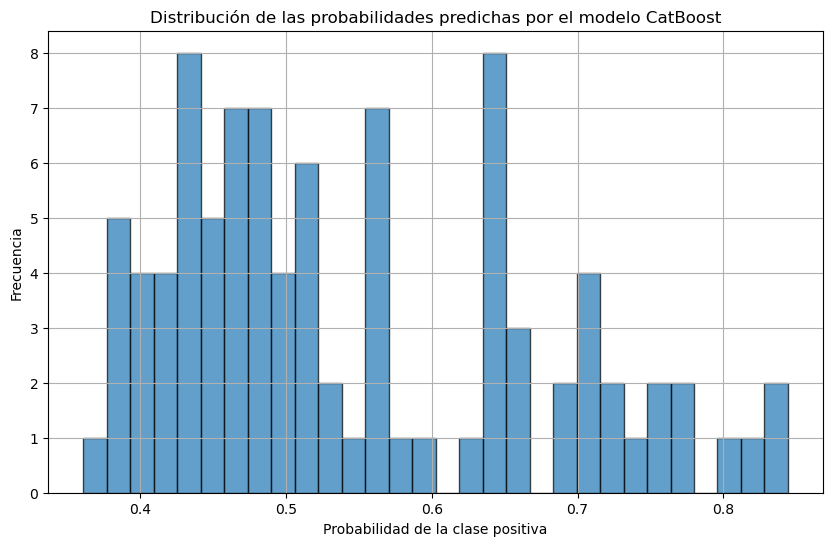

In [52]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes calculado y_pred_proba como:
# y_pred_proba = modelo_random_forest.predict_proba(X)[:, 1]

# Graficar las probabilidades predichas por el modelo
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de las probabilidades predichas por el modelo CatBoost')
plt.xlabel('Probabilidad de la clase positiva')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


ROC AUC: 0.6863839285714286


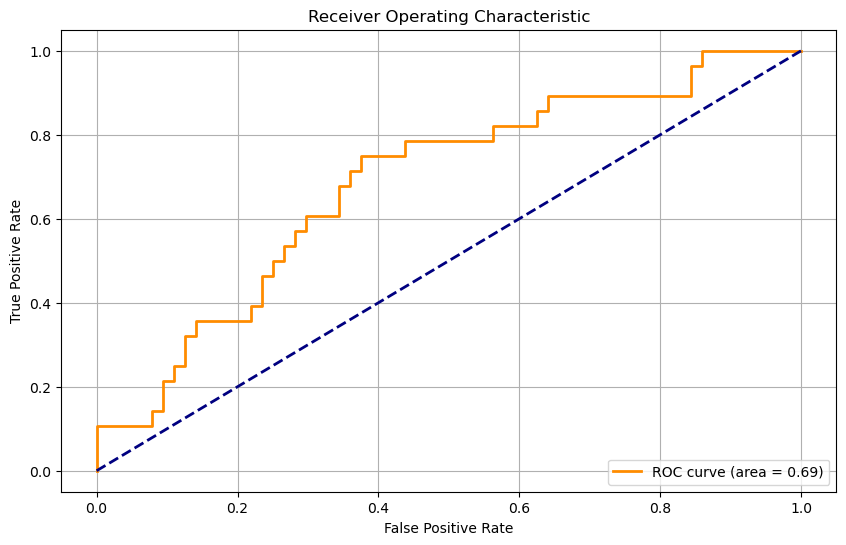

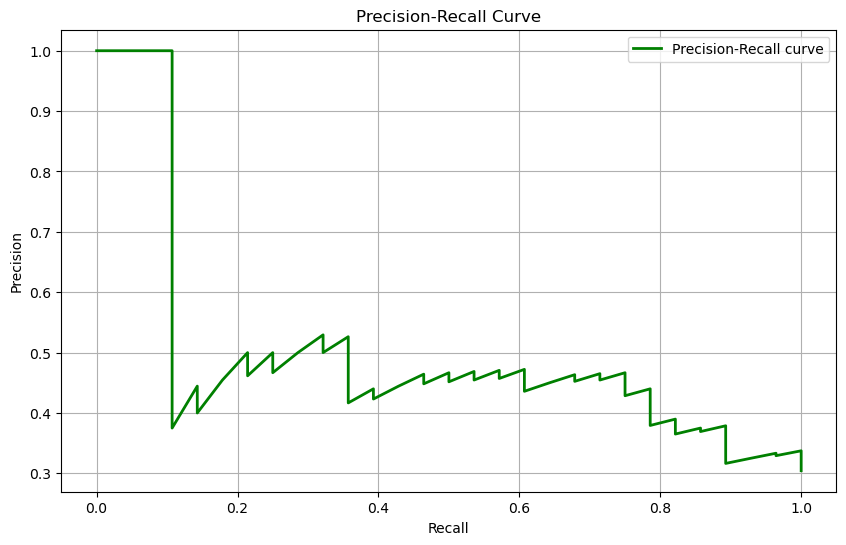

Classification Report for threshold = 0.2:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        64
         1.0       0.30      1.00      0.47        28

    accuracy                           0.30        92
   macro avg       0.15      0.50      0.23        92
weighted avg       0.09      0.30      0.14        92

Classification Report for threshold = 0.3:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        64
         1.0       0.30      1.00      0.47        28

    accuracy                           0.30        92
   macro avg       0.15      0.50      0.23        92
weighted avg       0.09      0.30      0.14        92

Classification Report for threshold = 0.4:
              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20        64
         1.0       0.33      1.00      0.50        28

    accuracy                           0.38        92

In [53]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Calcular AUC ROC
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC:", roc_auc)

# Curva ROC
fpr, tpr, roc_thresholds = roc_curve(y, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Curva Precision-Recall
precision, recall, pr_thresholds = precision_recall_curve(y, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Calcular y mostrar la clasificación de informes y la matriz de confusión para varios umbrales
thresholds = [0.2,0.3,0.4, 0.5,0.6, 0.7,0.8]
for thresh in thresholds:
    y_pred_thresh = np.where(y_pred_proba >= thresh, 1, 0)
    print(f"Classification Report for threshold = {thresh}:")
    print(classification_report(y, y_pred_thresh))

    # Podrías calcular más métricas específicas si es necesario


# MODELADO CORTOS 

In [84]:
from backtesting import Backtest, Strategy

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia bajista
def is_bearish_trend(ema_fast, ema_slow):
    return ema_fast < ema_slow

class EMARSIWithPipMarginStrategyShort(Strategy):
    risk_reward_ratio = 1.0
    risk_amount = 100  # con 5% de riesgo por operación, llega a un 97% de dd con un return del 52%

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variable para resetear señales
        self.rsi_above_90 = False  # Para manejar las señales de venta

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # Solo identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False
          
    def next(self):
        # Verificar si estamos dentro de la ventana de no operación (10 velas antes del cierre)
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]
        
        ### Lógica de venta (cortos)
        if is_bearish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia arriba del nivel 90 del RSI (crossover)
            if crossover(self.rsi, 90) and not self.rsi_above_90:
                self.rsi_above_90 = True  # Marcamos que el RSI ha cruzado hacia arriba
            
            # Luego detectamos el cruce hacia abajo del nivel 90 (crossunder) después de haber cruzado hacia arriba
            if self.rsi_above_90 and crossunder(self.rsi, 90):
                sl = self.data.High[-5:].max() + (margen_pips * valor_pip)
                tp = self.data.Close[-1] - (sl - self.data.Close[-1]) * self.risk_reward_ratio
                
                risk_per_unit = sl - self.data.Close[-1]
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.sell(size=size, sl=sl, tp=tp)
                
                self.rsi_above_90 = False  # Reiniciamos la señal para el siguiente ciclo

# Ejecutar el backtest con la estrategia combinada
bt_entrenamiento_shorts = Backtest(dataf_entrenamiento, EMARSIWithPipMarginStrategyShort, cash=10000, margin=1/10000, commission=.000)
stats_entrenamiento_shorts = bt_entrenamiento_shorts.run()
stats_entrenamiento_shorts


Start                     2021-01-04 10:16:00
End                       2024-04-25 15:59:00
Duration                   1207 days 05:43:00
Exposure Time [%]                    1.175703
Equity Final [$]                     9496.174
Equity Peak [$]                     12463.299
Return [%]                           -5.03826
Buy & Hold Return [%]               20.673656
Return (Ann.) [%]                   -1.512126
Volatility (Ann.) [%]               12.794077
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.504002
Avg. Drawdown [%]                   -1.961905
Max. Drawdown Duration      489 days 08:41:00
Avg. Drawdown Duration       27 days 20:04:00
# Trades                                  735
Win Rate [%]                        49.659864
Best Trade [%]                       0.245762
Worst Trade [%]                     -0.271806
Avg. Trade [%]                    

In [130]:
trades_shorts = stats_entrenamiento_shorts['_trades']
trades_shorts.describe()



,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,7.350000e+02,735,735,735
mean,-120.504762,285707.485714,285715.503401,1869.689261,1869.688835,-0.685478,-6.360200e-07,2022-09-07 03:57:02.857142784,2022-09-07 04:05:04,0 days 00:08:01.142857142
min,-487.000000,1764.000000,1766.000000,1624.550000,1623.705000,-100.000000,-2.718059e-03,2021-01-07 06:40:00,2021-01-07 06:42:00,0 days 00:00:00
25%,-151.500000,138912.000000,138921.000000,1783.188500,1784.168000,-99.560000,-4.827932e-04,2021-10-26 22:58:00,2021-10-26 23:07:00,0 days 00:02:00
50%,-108.000000,294364.000000,294375.000000,1854.130000,1854.586000,-97.604000,-1.657052e-04,2022-09-23 13:14:00,2022-09-23 13:25:00,0 days 00:04:00
75%,-74.000000,426427.500000,426434.000000,1947.217500,1948.042500,99.540000,5.196593e-04,2023-07-05 21:11:30,2023-07-05 21:18:00,0 days 00:10:00
max,-19.000000,562892.000000,562893.000000,2381.730000,2382.710000,100.000000,2.457619e-03,2024-04-24 12:44:00,2024-04-24 12:45:00,0 days 01:37:00
std,64.652938,163459.997533,163460.192930,125.452102,125.431069,99.524204,7.002194e-04,NaN,NaN,0 days 00:10:47.386529672


In [131]:
# Dropeo las columnas que no voy a utilizar
trades_shorts = trades_shorts.drop(columns = ['Size','EntryBar','ExitBar','ReturnPct'])

#Creo la variable objetivo 
trades_shorts['result'] = trades_shorts['PnL'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else np.nan)).astype('Int64')

#El backtest se realiza entrando en el opening de la vela que dio la senal por lo cual nuestras condiciones es una vela antes por esto hago el ajuste
trades_shorts['AdjustedEntryTime'] = trades_shorts['EntryTime'] - pd.Timedelta(minutes=1)

trades_shorts



,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result,AdjustedEntryTime
0,1924.597,1925.602,-99.495,2021-01-07 06:40:00,2021-01-07 06:42:00,0 days 00:02:00,0,2021-01-07 06:39:00
1,1926.517,1927.267,-99.750,2021-01-07 06:45:00,2021-01-07 06:46:00,0 days 00:01:00,0,2021-01-07 06:44:00
2,1918.702,1915.934,99.648,2021-01-07 11:32:00,2021-01-07 11:44:00,0 days 00:12:00,1,2021-01-07 11:31:00
3,1847.142,1844.860,98.126,2021-01-11 06:35:00,2021-01-11 06:40:00,0 days 00:05:00,1,2021-01-11 06:34:00
4,1860.210,1859.585,100.000,2021-01-13 05:07:00,2021-01-13 05:10:00,0 days 00:03:00,1,2021-01-13 05:06:00
...,...,...,...,...,...,...,...,...
730,2381.730,2382.710,-99.960,2024-04-18 10:28:00,2024-04-18 10:32:00,0 days 00:04:00,0,2024-04-18 10:27:00
731,2362.535,2361.090,99.705,2024-04-22 09:26:00,2024-04-22 09:32:00,0 days 00:06:00,1,2024-04-22 09:25:00
732,2349.320,2347.985,98.790,2024-04-22 12:36:00,2024-04-22 12:36:00,0 days 00:00:00,1,2024-04-22 12:35:00
733,2306.560,2309.035,-99.000,2024-04-23 12:10:00,2024-04-23 12:25:00,0 days 00:15:00,0,2024-04-23 12:09:00


In [132]:
import numpy as np
df_trading = dataf_entrenamiento.copy()
df_backtest = trades_shorts.copy()

# Vamos a eliminar open,high,low y promedio ohlcavg4

# Respecto al precio 
# 1. Variación porcentual entre Open y Close
df_trading['perc_var_open_close'] = ((df_trading['Close'] - df_trading['Open']) / df_trading['Open']) * 100

# 2. Rango de la vela en porcentaje
df_trading['candle_range_perc'] = ((df_trading['High'] - df_trading['Low']) / df_trading['Open']) * 100

# 3. Tamaño del cuerpo de la vela en porcentaje
df_trading['body_size_perc'] = (abs(df_trading['Close'] - df_trading['Open']) / df_trading['Open']) * 100

# 4. Tamaño de las sombras (mechas) en porcentaje
df_trading['upper_shadow_perc'] = ((df_trading['High'] - df_trading[['Open', 'Close']].max(axis=1)) / df_trading['Open']) * 100
df_trading['lower_shadow_perc'] = ((df_trading[['Open', 'Close']].min(axis=1) - df_trading['Low']) / df_trading['Open']) * 100

# 5. Ratios de las sombras y el cuerpo respecto al rango total
df_trading['upper_shadow_ratio'] = df_trading['upper_shadow_perc'] / df_trading['candle_range_perc']
df_trading['lower_shadow_ratio'] = df_trading['lower_shadow_perc'] / df_trading['candle_range_perc']
df_trading['body_to_range_ratio'] = df_trading['body_size_perc'] / df_trading['candle_range_perc']

#  Estadísticas sobre ventanas de tiempo (por ejemplo, últimas 5 y 10 velas)
windows = [3] # Probare con 10 primeramente 
for window in windows:
    # Variación porcentual promedio entre Open y Close
    df_trading[f'perc_var_open_close_mean_{window}'] = df_trading['perc_var_open_close'].rolling(window).mean()
    df_trading[f'perc_var_open_close_std_{window}'] = df_trading['perc_var_open_close'].rolling(window).std()
    df_trading[f'perc_var_open_close_min_{window}'] = df_trading['perc_var_open_close'].rolling(window).min()
    df_trading[f'perc_var_open_close_max_{window}'] = df_trading['perc_var_open_close'].rolling(window).max()
    df_trading[f'perc_var_open_close_median_{window}'] = df_trading['perc_var_open_close'].rolling(window).median()
        
    # Rango de la vela
    df_trading[f'candle_range_perc_mean_{window}'] = df_trading['candle_range_perc'].rolling(window).mean()
    df_trading[f'candle_range_perc_std_{window}'] = df_trading['candle_range_perc'].rolling(window).std()
    df_trading[f'candle_range_perc_min_{window}'] = df_trading['candle_range_perc'].rolling(window).min()
    df_trading[f'candle_range_perc_max_{window}'] = df_trading['candle_range_perc'].rolling(window).max()
    df_trading[f'candle_range_perc_median_{window}'] = df_trading['candle_range_perc'].rolling(window).median()
        
    # Ratios de las sombras y el cuerpo
    df_trading[f'upper_shadow_ratio_mean_{window}'] = df_trading['upper_shadow_ratio'].rolling(window).mean()
    df_trading[f'upper_shadow_ratio_std_{window}'] = df_trading['upper_shadow_ratio'].rolling(window).std()
    df_trading[f'lower_shadow_ratio_mean_{window}'] = df_trading['lower_shadow_ratio'].rolling(window).mean()
    df_trading[f'lower_shadow_ratio_std_{window}'] = df_trading['lower_shadow_ratio'].rolling(window).std()
    df_trading[f'body_to_range_ratio_mean_{window}'] = df_trading['body_to_range_ratio'].rolling(window).mean()
    df_trading[f'body_to_range_ratio_std_{window}'] = df_trading['body_to_range_ratio'].rolling(window).std()

# Respecto al RSI8, haras lo mismo para el RSI DE 14? Y VARIOS?

# Valores estadísticos
windows = [3]
for window in windows:
    df_trading[f'RSI8_mean_{window}'] = df_trading['RSI8'].rolling(window).mean()
    df_trading[f'RSI8_std_{window}'] = df_trading['RSI8'].rolling(window).std()
    df_trading[f'RSI8_min_{window}'] = df_trading['RSI8'].rolling(window).min()
    df_trading[f'RSI8_25%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.25)
    df_trading[f'RSI8_50%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.50)
    df_trading[f'RSI8_75%_{window}'] = df_trading['RSI8'].rolling(window).quantile(0.75)
    df_trading[f'RSI8_max_{window}'] = df_trading['RSI8'].rolling(window).max()

# Calcular la pendiente del RSI usando diferencias finitas
df_trading['RSI8_slope_5'] = (df_trading['RSI8'] - df_trading['RSI8'].shift(3)) / 3
#df_trading['RSI8_slope_10'] = (df_trading['RSI8'] - df_trading['RSI8'].shift(10)) / 10

# Cuántas veces cruzó en un periodo de tiempo
# Crear una serie booleana que indique cuando el RSI8 cruza el nivel 90 hacia arriba
df_trading['RSI8_crossed_above_90'] = ((df_trading['RSI8'] > 90) & (df_trading['RSI8'].shift(1) <= 90)).astype(int)
# Contar el número de cruces hacia arriba en las últimas 20 velas
df_trading['RSI8_crosses_above_90_count_20'] = df_trading['RSI8_crossed_above_90'].rolling(window=20).sum()


# EMAS, MANTENEMOS LOS VALORES DE LA VELA DE ENTRADA 

windows = [3]
for window in windows:
    # EMA70
    df_trading[f'EMA70_mean_{window}'] = df_trading['EMA70'].rolling(window).mean()
    df_trading[f'EMA70_std_{window}'] = df_trading['EMA70'].rolling(window).std()
    df_trading[f'EMA70_min_{window}'] = df_trading['EMA70'].rolling(window).min()
    df_trading[f'EMA70_max_{window}'] = df_trading['EMA70'].rolling(window).max()
    df_trading[f'EMA70_median_{window}'] = df_trading['EMA70'].rolling(window).median()
        
    # EMA250
    df_trading[f'EMA250_mean_{window}'] = df_trading['EMA250'].rolling(window).mean()
    df_trading[f'EMA250_std_{window}'] = df_trading['EMA250'].rolling(window).std()
    df_trading[f'EMA250_min_{window}'] = df_trading['EMA250'].rolling(window).min()
    df_trading[f'EMA250_max_{window}'] = df_trading['EMA250'].rolling(window).max()
    df_trading[f'EMA250_median_{window}'] = df_trading['EMA250'].rolling(window).median()

df_trading['ema_diff'] = df_trading['EMA70'] - df_trading['EMA250']
for window in windows:
    df_trading[f'ema_diff_mean_{window}'] = df_trading['ema_diff'].rolling(window).mean()
    df_trading[f'ema_diff_std_{window}'] = df_trading['ema_diff'].rolling(window).std()
    df_trading[f'ema_diff_min_{window}'] = df_trading['ema_diff'].rolling(window).min()
    df_trading[f'ema_diff_max_{window}'] = df_trading['ema_diff'].rolling(window).max()
    df_trading[f'ema_diff_median_{window}'] = df_trading['ema_diff'].rolling(window).median()

df_trading['close_to_ema70'] = df_trading['Close'] - df_trading['EMA70']
df_trading['close_to_ema250'] = df_trading['Close'] - df_trading['EMA250']
for window in windows:
    df_trading[f'close_to_ema70_mean_{window}'] = df_trading['close_to_ema70'].rolling(window).mean()
    df_trading[f'close_to_ema70_std_{window}'] = df_trading['close_to_ema70'].rolling(window).std()
    df_trading[f'close_to_ema250_mean_{window}'] = df_trading['close_to_ema250'].rolling(window).mean()
    df_trading[f'close_to_ema250_std_{window}'] = df_trading['close_to_ema250'].rolling(window).std()

df_trading['EMA_ratio'] = df_trading['EMA70'] / df_trading['EMA250']
for window in windows:
    df_trading[f'EMA_ratio_mean_{window}'] = df_trading['EMA_ratio'].rolling(window).mean()
    df_trading[f'EMA_ratio_std_{window}'] = df_trading['EMA_ratio'].rolling(window).std()


# Calcular la pendiente de la EMA70 usando diferencias finitas
df_trading['EMA70_slope_5'] = (df_trading['EMA70'] - df_trading['EMA70'].shift(3)) / 3
#df_trading['EMA70_slope_10'] = (df_trading['EMA70'] - df_trading['EMA70'].shift(10)) / 10

# Calcular la pendiente de la EMA250 usando diferencias finitas
df_trading['EMA250_slope_5'] = (df_trading['EMA250'] - df_trading['EMA250'].shift(3)) / 3
#df_trading['EMA250_slope_10'] = (df_trading['EMA250'] - df_trading['EMA250'].shift(10)) / 10

# Calcular la pendiente de ema_diff (diferencia entre EMA70 y EMA250) usando diferencias finitas
df_trading['ema_diff_slope_5'] = (df_trading['ema_diff'] - df_trading['ema_diff'].shift(3)) / 3
#df_trading['ema_diff_slope_10'] = (df_trading['ema_diff'] - df_trading['ema_diff'].shift(10)) / 10


# AHORA VOLUMEN Y ATR 

# 1. Indicadores de Volatilidad
df_trading['atr_14'] = ta.atr(df_trading['High'], df_trading['Low'], df_trading['Close'], length=14)

# Calcular estadísticas del atr_14 en ventanas de 5 y 10 períodos
windows = [3]
for window in windows:
    df_trading[f'atr_14_mean_{window}'] = df_trading['atr_14'].rolling(window).mean()
    df_trading[f'atr_14_std_{window}'] = df_trading['atr_14'].rolling(window).std()
    df_trading[f'atr_14_min_{window}'] = df_trading['atr_14'].rolling(window).min()
    df_trading[f'atr_14_max_{window}'] = df_trading['atr_14'].rolling(window).max()
    df_trading[f'atr_14_median_{window}'] = df_trading['atr_14'].rolling(window).median()

# Calcular la pendiente del ATR14 usando diferencias finitas
df_trading['atr_14_slope_5'] = (df_trading['atr_14'] - df_trading['atr_14'].shift(3)) / 3
#df_trading['atr_14_slope_10'] = (df_trading['atr_14'] - df_trading['atr_14'].shift(10)) / 10


# Volumen
for window in windows:
    df_trading[f'Volume_mean_{window}'] = df_trading['Volume'].rolling(window).mean()
    df_trading[f'Volume_std_{window}'] = df_trading['Volume'].rolling(window).std()
    df_trading[f'Volume_min_{window}'] = df_trading['Volume'].rolling(window).min()
    df_trading[f'Volume_max_{window}'] = df_trading['Volume'].rolling(window).max()
    df_trading[f'Volume_median_{window}'] = df_trading['Volume'].rolling(window).median()

for window in windows:
    df_trading[f'Volume_relative_{window}'] = df_trading['Volume'] / df_trading[f'Volume_mean_{window}']

# OBV

df_trading['obv'] = ta.obv(df_trading['Close'], df_trading['Volume'])

# Cálculos adicionales: media, desviación estándar, y pendiente
windows = [3]
for window in windows:
    # Media móvil del OBV
    df_trading[f'obv_mean_{window}'] = df_trading['obv'].rolling(window).mean()
    
    # Desviación estándar del OBV
    df_trading[f'obv_std_{window}'] = df_trading['obv'].rolling(window).std()
    
    # Pendiente del OBV (usando la función optimizada de pendientes)
    df_trading[f'obv_slope_{window}'] = (df_trading['obv'] - df_trading['obv'].shift(window)) / window

    

# Calcular CMF usando pandas-ta con una ventana de 20 (puedes ajustar el valor de la ventana)
df_trading['cmf_20'] = ta.cmf(df_trading['High'], df_trading['Low'], df_trading['Close'], df_trading['Volume'], length=20)

# Estadísticas adicionales para CMF
windows = [3]  # Ventanas para calcular las estadísticas
for window in windows:
    # Media móvil del CMF
    df_trading[f'cmf_mean_{window}'] = df_trading['cmf_20'].rolling(window).mean()
    
    # Desviación estándar del CMF
    df_trading[f'cmf_std_{window}'] = df_trading['cmf_20'].rolling(window).std()
    
    # Pendiente del CMF usando diferencias finitas
    df_trading[f'cmf_slope_{window}'] = (df_trading['cmf_20'] - df_trading['cmf_20'].shift(window)) / window




# Crear un DataFrame temporal para las nuevas columnas
new_columns = pd.DataFrame(index=df_trading.index)

# RETORNOS Y VOLATILIDAD

# 1. Volatilidad basada en retornos porcentuales con una ventana de 14 períodos
new_columns['volatility_14'] = df_trading['Close'].pct_change().rolling(window=14).std()

# 2. Retornos retrospectivos
new_columns['return_5'] = df_trading['Close'].pct_change(3)
#new_columns['return_10'] = df_trading['Close'].pct_change(10)

# 3. Retornos ajustados por riesgo (evitando divisiones por cero)
new_columns['risk_adjusted_return_5'] = new_columns['return_5'] / new_columns['volatility_14'].replace(0, np.nan)
#new_columns['risk_adjusted_return_10'] = new_columns['return_10'] / new_columns['volatility_14'].replace(0, np.nan)

# 4. Relación entre RSI y volatilidad (asegurando que no haya divisiones por cero)
new_columns['rsi_volatility_ratio'] = df_trading['RSI8'] / df_trading['atr_14'].replace(0, np.nan)

# 5. Calcular estadísticas y pendientes en una ventana de 10 períodos
window = 3

# Volatilidad
new_columns[f'volatility_14_mean_{window}'] = new_columns['volatility_14'].rolling(window).mean()
new_columns[f'volatility_14_std_{window}'] = new_columns['volatility_14'].rolling(window).std()
new_columns[f'volatility_14_min_{window}'] = new_columns['volatility_14'].rolling(window).min()
new_columns[f'volatility_14_max_{window}'] = new_columns['volatility_14'].rolling(window).max()
new_columns[f'volatility_14_median_{window}'] = new_columns['volatility_14'].rolling(window).median()
new_columns[f'volatility_14_slope_{window}'] = (new_columns['volatility_14'] - new_columns['volatility_14'].shift(window)) / window

# Retornos
new_columns[f'return_5_mean_{window}'] = new_columns['return_5'].rolling(window).mean()
new_columns[f'return_5_std_{window}'] = new_columns['return_5'].rolling(window).std()
#new_columns[f'return_10_mean_{window}'] = new_columns['return_10'].rolling(window).mean()
#new_columns[f'return_10_std_{window}'] = new_columns['return_10'].rolling(window).std()

# Retornos ajustados por riesgo
new_columns[f'risk_adjusted_return_5_mean_{window}'] = new_columns['risk_adjusted_return_5'].rolling(window).mean()
new_columns[f'risk_adjusted_return_5_std_{window}'] = new_columns['risk_adjusted_return_5'].rolling(window).std()
#new_columns[f'risk_adjusted_return_10_mean_{window}'] = new_columns['risk_adjusted_return_10'].rolling(window).mean()
#new_columns[f'risk_adjusted_return_10_std_{window}'] = new_columns['risk_adjusted_return_10'].rolling(window).std()

# Relación RSI y volatilidad
new_columns[f'rsi_volatility_ratio_mean_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).mean()
new_columns[f'rsi_volatility_ratio_std_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).std()
new_columns[f'rsi_volatility_ratio_min_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).min()
new_columns[f'rsi_volatility_ratio_max_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).max()
new_columns[f'rsi_volatility_ratio_median_{window}'] = new_columns['rsi_volatility_ratio'].rolling(window).median()
new_columns[f'rsi_volatility_ratio_slope_{window}'] = (new_columns['rsi_volatility_ratio'] - new_columns['rsi_volatility_ratio'].shift(window)) / window

# 6. Unir todas las nuevas columnas al DataFrame original
df_trading = pd.concat([df_trading, new_columns], axis=1)

# 7. Eliminar filas con valores NaN generados por los cálculos
df_trading.dropna(inplace=True)

# Eliminar columna RSI8 si ya no es necesaria
df_trading.drop(columns=['RSI8'], inplace=True)

# Visualizar el dataframe final
df_trading



,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,RSI8_crossed_above_90,RSI8_crosses_above_90_count_20,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 11:00:00,1933.610,1934.062,1933.610,1934.062,23,1933.83600,1931.896348,1929.141144,0.023376,0.023376,0.023376,0.000000,0.000000,0.000000,0.000000,1.000000,0.002621,0.019495,-0.015306,0.023376,-0.000207,0.019255,0.008939,0.008999,0.025389,0.023376,0.076628,0.132724,0.381425,0.373811,0.541947,0.491345,67.776265,2.673554,64.689170,66.996141,69.303112,69.319812,69.336512,-3.645886,1931.841965,0.053488,1931.789420,1931.896348,1931.840127,1929.103994,0.036874,1929.067402,1929.141144,1929.103435,2.755204,2.737971,0.016630,2.722018,2.755204,2.736692,2.165652,4.920856,1.920035,0.214462,4.658006,0.228513,1.001428,1.001419,0.000009,0.054230,0.037019,0.017211,0.589987,0.613202,0.029342,0.589987,0.646181,0.603439,-0.023999,20.000000,5.196152,14.0,23.0,23.0,1.150000,219.0,208.333333,11.590226,-4.666667,0.122129,0.101866,0.024522,0.017542,0.000232,0.000079,0.338478,116.008186,0.000237,0.000007,0.000232,0.000245,0.000232,-0.000007,-9.772417e-05,0.000159,-0.410085,0.682179,109.902353,5.333025,106.156428,116.008186,107.542446,-2.069306,0,0.0,0.000232,0.000079,0.338478,117.522083,0.000237,0.000007,0.000232,0.000245,0.000232,-0.000007,-9.772417e-05,0.000159,-0.410085,0.682179,110.657745,5.944743,107.200893,117.522083,107.250258,-1.246976
2021-01-04 11:01:00,1934.062,1935.034,1933.972,1934.862,47,1934.48250,1931.969198,1929.183705,0.041364,0.054910,0.041364,0.008893,0.004653,0.161959,0.084746,0.753296,0.021511,0.020848,-0.000207,0.041364,0.023376,0.029095,0.023484,0.008999,0.054910,0.023376,0.130615,0.118104,

In [133]:
# Realizar el merge utilizando el índice de df_trading y la columna AdjustedEntryTime de df_backtest
df_merged_shorts = df_trading.merge(df_backtest, how='left', left_index=True, right_on='AdjustedEntryTime')

# Eliminar la columna AdjustedEntryTime después del merge si no es necesaria
df_merged_shorts.drop(columns=['AdjustedEntryTime'], inplace=True)

# Mantener el índice 'time' original de df_trading
df_merged_shorts.set_index(df_trading.index, inplace=True)

df_merged_shorts

,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,RSI8_crossed_above_90,RSI8_crosses_above_90_count_20,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04 11:00:00,1933.610,1934.062,1933.610,1934.062,23,1933.83600,1931.896348,1929.141144,0.023376,0.023376,0.023376,0.000000,0.000000,0.000000,0.000000,1.000000,0.002621,0.019495,-0.015306,0.023376,-0.000207,0.019255,0.008939,0.008999,0.025389,0.023376,0.076628,0.132724,0.381425,0.373811,0.541947,0.491345,67.776265,2.673554,64.689170,66.996141,69.303112,69.319812,69.336512,-3.645886,1931.841965,0.053488,1931.789420,1931.896348,1931.840127,1929.103994,0.036874,1929.067402,1929.141144,1929.103435,2.755204,2.737971,0.016630,2.722018,2.755204,2.736692,2.165652,4.920856,1.920035,0.214462,4.658006,0.228513,1.001428,1.001419,0.000009,0.054230,0.037019,0.017211,0.589987,0.613202,0.029342,0.589987,0.646181,0.603439,-0.023999,20.000000,5.196152,14.0,23.0,23.0,1.150000,219.0,208.333333,11.590226,-4.666667,0.122129,0.101866,0.024522,0.017542,0.000232,0.000079,0.338478,116.008186,0.000237,0.000007,0.000232,0.000245,0.000232,-0.000007,-9.772417e-05,0.000159,-0.410085,0.682179,109.902353,5.333025,106.156428,116.008186,107.542446,-2.069306,0,0.0,0.000232,0.000079,0.338478,117.522083,0.000237,0.000007,0.000232,0.000245,0.000232,-0.000007,-9.772417e-05,0.000159,-0.410085,0.682179,110.657745,5.944743,107.200893,117.522083,107.250258,-1.246976,NaN,NaN,NaN,NaT,NaT,NaT,<NA>
2021-01-04 11:01:00,1934.062,1935.034,1933.972,1934.862,47,1934.48250,1931.969198,1929.183705,0.041364,0.054910,0.041364,0.008893,0.004653,0.161959,0.084746,0.753296,0.021511,0.02

In [134]:
# Filtrar las filas donde el valor de 'result' es 0 o 1
df2 = df_merged_shorts[df_merged_shorts['result'].isin([0, 1])]

pd.set_option('display.max_columns', None)

# #pd.reset_option('display.max_columns')# Volver como antes



# Mostrar las primeras filas del DataFrame filtrado
df2.head(20)



,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,perc_var_open_close,candle_range_perc,body_size_perc,upper_shadow_perc,lower_shadow_perc,upper_shadow_ratio,lower_shadow_ratio,body_to_range_ratio,perc_var_open_close_mean_3,perc_var_open_close_std_3,perc_var_open_close_min_3,perc_var_open_close_max_3,perc_var_open_close_median_3,candle_range_perc_mean_3,candle_range_perc_std_3,candle_range_perc_min_3,candle_range_perc_max_3,candle_range_perc_median_3,upper_shadow_ratio_mean_3,upper_shadow_ratio_std_3,lower_shadow_ratio_mean_3,lower_shadow_ratio_std_3,body_to_range_ratio_mean_3,body_to_range_ratio_std_3,RSI8_mean_3,RSI8_std_3,RSI8_min_3,RSI8_25%_3,RSI8_50%_3,RSI8_75%_3,RSI8_max_3,RSI8_slope_5,EMA70_mean_3,EMA70_std_3,EMA70_min_3,EMA70_max_3,EMA70_median_3,EMA250_mean_3,EMA250_std_3,EMA250_min_3,EMA250_max_3,EMA250_median_3,ema_diff,ema_diff_mean_3,ema_diff_std_3,ema_diff_min_3,ema_diff_max_3,ema_diff_median_3,close_to_ema70,close_to_ema250,close_to_ema70_mean_3,close_to_ema70_std_3,close_to_ema250_mean_3,close_to_ema250_std_3,EMA_ratio,EMA_ratio_mean_3,EMA_ratio_std_3,EMA70_slope_5,EMA250_slope_5,ema_diff_slope_5,atr_14,atr_14_mean_3,atr_14_std_3,atr_14_min_3,atr_14_max_3,atr_14_median_3,atr_14_slope_5,Volume_mean_3,Volume_std_3,Volume_min_3,Volume_max_3,Volume_median_3,Volume_relative_3,obv,obv_mean_3,obv_std_3,obv_slope_3,cmf_20,cmf_mean_3,cmf_std_3,cmf_slope_3,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,RSI8_crossed_above_90,RSI8_crosses_above_90_count_20,volatility_14,return_5,risk_adjusted_return_5,rsi_volatility_ratio,volatility_14_mean_3,volatility_14_std_3,volatility_14_min_3,volatility_14_max_3,volatility_14_median_3,volatility_14_slope_3,return_5_mean_3,return_5_std_3,risk_adjusted_return_5_mean_3,risk_adjusted_return_5_std_3,rsi_volatility_ratio_mean_3,rsi_volatility_ratio_std_3,rsi_volatility_ratio_min_3,rsi_volatility_ratio_max_3,rsi_volatility_ratio_median_3,rsi_volatility_ratio_slope_3,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration,result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-07 06:39:00,1925.318,1925.402,1924.022,1924.597,73,1924.83475,1921.263276,1925.910481,-0.037448,0.071676,0.037448,0.004363,0.029865,0.060870,0.416667,0.522464,0.013052,0.044712,-0.037448,0.047599,0.029004,0.055213,0.015477,0.040960,0.071676,0.053003,0.120578,0.115586,0.169880,0.213889,0.709542,0.187792,89.184835,1.744494,87.240118,88.471272,89.702426,90.157194,90.611962,2.394075,1921.158530,0.105364,1921.052559,1921.263276,1921.159755,1925.919082,0.008582,1925.910481,1925.927644,1925.919121,-4.647205,-4.760552,0.113945,-4.875085,-4.647205,-4.759366,3.333724,-1.313481,3.613803,0.471566,-1.146749,0.484289,0.997587,0.997528,0.000059,0.100316,-0.010439,0.110755,0.628277,0.578200,0.046687,0.535871,0.628277,0.570452,0.037267,59.666667,13.503086,46.0,73.0,60.0,1.223464,-6125.0,-6096.333333,38.940125,11.000000,0.348088,0.353624,0.019717,0.008541,0.000235,0.000391,1.663299,142.775350,0.000203,0.000031,0.000175,0.000235,0.000199,0.000022,0.000709,0.000344,3.618960,1.875396,154.806109,10.605234,142.775350,162.800534,158.842444,-5.666639,0,1.0,0.000235,0.000391,1.663299,142.775350,0.000203,0.000031,0.000175,0.000235,0.000199,0.000022,0.000709,0.000344,3.618960,1.875396,154.806109,10.605234,142.775350,162.800534,158.842444,-5.666639,1924.597,1925.602,-99.495,2021-01-07 06:40:00,2021-01-07 06:42:00,0 days 00:02:00,0
2021-01-07 06:44:00,1925.617,1926.517,1925.617,1926.517,92,1926.06700,1921.852531,1925.901222,0.046738,0.046738,0.046738,0.00

## Modelado

In [135]:
for col in df2.columns:
    print(col)


Open
High
Low
Close
Volume
ohlc_avg
EMA70
EMA250
perc_var_open_close
candle_range_perc
body_size_perc
upper_shadow_perc
lower_shadow_perc
upper_shadow_ratio
lower_shadow_ratio
body_to_range_ratio
perc_var_open_close_mean_3
perc_var_open_close_std_3
perc_var_open_close_min_3
perc_var_open_close_max_3
perc_var_open_close_median_3
candle_range_perc_mean_3
candle_range_perc_std_3
candle_range_perc_min_3
candle_range_perc_max_3
candle_range_perc_median_3
upper_shadow_ratio_mean_3
upper_shadow_ratio_std_3
lower_shadow_ratio_mean_3
lower_shadow_ratio_std_3
body_to_range_ratio_mean_3
body_to_range_ratio_std_3
RSI8_mean_3
RSI8_std_3
RSI8_min_3
RSI8_25%_3
RSI8_50%_3
RSI8_75%_3
RSI8_max_3
RSI8_slope_5
EMA70_mean_3
EMA70_std_3
EMA70_min_3
EMA70_max_3
EMA70_median_3
EMA250_mean_3
EMA250_std_3
EMA250_min_3
EMA250_max_3
EMA250_median_3
ema_diff
ema_diff_mean_3
ema_diff_std_3
ema_diff_min_3
ema_diff_max_3
ema_diff_median_3
close_to_ema70
close_to_ema250
close_to_ema70_mean_3
close_to_ema70_std_3
close

In [136]:
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Ajustar la variable de entorno para evitar la advertencia de joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "14"  # Ajustar según el sistema

# Eliminar columnas irrelevantes para el modelado
columns_to_drop2 = ['EntryPrice','ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration', 'result','RSI8_crossed_above_90']

# Separar características (X) y la variable objetivo (y)
X_features = df2.drop(columns=columns_to_drop2)
y_target = df2['result']

# Definir el número de divisiones (folds) para la validación cruzada temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lista de clasificadores
classifiers = [
    XGBClassifier(random_state=42, eval_metric='logloss'),
    LGBMClassifier(random_state=42, verbose=-1),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42)
]

# Diccionario para almacenar modelos entrenados
trained_classifiers = {}

# Entrenamiento y evaluación de los modelos con TimeSeriesSplit
for clf in classifiers:
    auc_scores = []  # Para almacenar los AUC de cada fold
    for train_index, test_index in tscv.split(X_features):  # Uso de nuevas variables
        # Separar los datos de entrenamiento y prueba
        X_train_split, X_test_split = X_features.iloc[train_index], X_features.iloc[test_index]
        y_train_split, y_test_split = y_target.iloc[train_index], y_target.iloc[test_index]
        
        # Entrenar el modelo
        clf.fit(X_train_split, y_train_split)
        
        # Predecir probabilidades para la clase positiva (1)
        y_pred_split = clf.predict_proba(X_test_split)[:, 1]
        
        # Calcular el AUC para este fold
        auc_score = roc_auc_score(y_test_split, y_pred_split)
        auc_scores.append(auc_score)
    
    # Calcular el AUC promedio de todas las particiones
    mean_auc_score = sum(auc_scores) / len(auc_scores)
    print(f'{type(clf).__name__}: Mean AUC Score={mean_auc_score:.3f}')
    
    # Almacenar el modelo entrenado
    trained_classifiers[type(clf).__name__] = clf


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [117]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo CatBoostClassifier
clf = CatBoostClassifier(random_state=42, silent=True)

# Hiperparámetros reducidos para optimización
param_grid = {
    'iterations': [200, 500, 1000],                # Número de iteraciones reducido
    'learning_rate': [0.05, 0.1],                  # Tasas de aprendizaje reducidas
    'depth': [6, 8, 10],                           # Profundidad máxima del árbol
    'l2_leaf_reg': [3, 5],                         # Regularización L2
    'scale_pos_weight': [1, 2]                     # Peso para clases desbalanceadas
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con menos combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=20, random_state=42)

# Entrenar y ajustar el modelo con las nuevas variables
random_search.fit(X_features, y_target)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'scale_pos_weight': 2, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 10}
Mejor modelo después de optimización: <catboost.core.CatBoostClassifier object at 0x000001FDC7983CD0>


In [119]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo CatBoostClassifier con los mejores hiperparámetros
modelo_catboost = CatBoostClassifier(
    iterations=200, 
    depth=10, 
    learning_rate=0.05, 
    l2_leaf_reg=3, 
    scale_pos_weight=2, 
    random_state=42,
    silent=True  # Mantener salida del entrenamiento en silencio
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X_features):
    X_train_split, X_test_split = X_features.iloc[train_index], X_features.iloc[test_index]
    y_train_split, y_test_split = y_target.iloc[train_index], y_target.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_catboost.fit(X_train_split, y_train_split)
    
    # Predicciones
    y_pred_split = modelo_catboost.predict(X_test_split)
    
    # Métricas
    accuracy = accuracy_score(y_test_split, y_pred_split)
    f1 = f1_score(y_test_split, y_pred_split)
    precision = precision_score(y_test_split, y_pred_split)
    recall = recall_score(y_test_split, y_pred_split)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test_split, y_pred_split))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test_split, y_pred_split))

# Promediar las métricas de los 10 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.516, F1-Score = 0.651, Precision = 0.534, Recall = 0.833

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.42      0.14      0.21        56
         1.0       0.53      0.83      0.65        66

    accuracy                           0.52       122
   macro avg       0.48      0.49      0.43       122
weighted avg       0.48      0.52      0.45       122

Matriz de Confusión:
[[ 8 48]
 [11 55]]
Fold: Accuracy = 0.467, F1-Score = 0.596, Precision = 0.466, Recall = 0.828

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.47      0.14      0.22        64
         1.0       0.47      0.83      0.60        58

    accuracy                           0.47       122
   macro avg       0.47      0.48      0.41       122
weighted avg       0.47      0.47      0.40       122

Matriz de Confusión:
[[ 9 55]
 [10 48]]
Fold: Accuracy = 0.500, F1-Score = 0.601, Precision = 0.505,

In [118]:
# Random

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Definir el modelo RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Hiperparámetros ampliados para optimización
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],           # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],                  # Profundidad máxima del árbol (None para sin límite)
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en cada hoja
    'max_features': ['auto', 'sqrt', 'log2'],         # Número de características a considerar para encontrar la mejor división
    'bootstrap': [True, False],                       # Método de muestreo (con reemplazo o sin reemplazo)
}

# Validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Realizar la búsqueda de hiperparámetros con más combinaciones
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, 
                                   cv=tscv, scoring='roc_auc', n_jobs=-1, n_iter=50, random_state=42)

# Entrenar y ajustar el modelo con las nuevas variables
random_search.fit(X_features, y_target)

# Imprimir los mejores parámetros encontrados
print(f"Mejores Hiperparámetros: {random_search.best_params_}")

# Ver el mejor modelo después de la optimización
best_model = random_search.best_estimator_

# Evaluar el mejor modelo
print(f"Mejor modelo después de optimización: {best_model}")


Mejores Hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Mejor modelo después de optimización: RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       n_estimators=200, random_state=42)


In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definir el modelo RandomForestClassifier con los mejores hiperparámetros
modelo_rf_shorts = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='log2', 
    bootstrap=False, 
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=7)

# Almacenar los resultados
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Validación cruzada temporal y evaluación del modelo
for train_index, test_index in tscv.split(X_features):
    X_train_split, X_test_split = X_features.iloc[train_index], X_features.iloc[test_index]
    y_train_split, y_test_split = y_target.iloc[train_index], y_target.iloc[test_index]
    
    # Entrenamiento del modelo optimizado
    modelo_rf_shorts.fit(X_train_split, y_train_split)
    
    # Predicciones
    y_pred_split = modelo_rf_shorts.predict(X_test_split)
    
    # Métricas
    accuracy = accuracy_score(y_test_split, y_pred_split)
    f1 = f1_score(y_test_split, y_pred_split)
    precision = precision_score(y_test_split, y_pred_split)
    recall = recall_score(y_test_split, y_pred_split)
    
    # Guardar resultados
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Imprimir las métricas para cada fold
    print(f"Fold: Accuracy = {accuracy:.3f}, F1-Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    
    # Reporte de clasificación y matriz de confusión para cada fold
    print("\nReporte de Clasificación:")
    print(classification_report(y_test_split, y_pred_split))
    
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test_split, y_pred_split))

# Promediar las métricas de los 7 folds
print(f"\nPromedio Accuracy: {np.mean(accuracy_scores):.3f}")
print(f"Promedio F1-Score: {np.mean(f1_scores):.3f}")
print(f"Promedio Precision: {np.mean(precision_scores):.3f}")
print(f"Promedio Recall: {np.mean(recall_scores):.3f}")


Fold: Accuracy = 0.451, F1-Score = 0.537, Precision = 0.460, Recall = 0.644

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.43      0.26      0.32        46
         1.0       0.46      0.64      0.54        45

    accuracy                           0.45        91
   macro avg       0.44      0.45      0.43        91
weighted avg       0.44      0.45      0.43        91

Matriz de Confusión:
[[12 34]
 [16 29]]
Fold: Accuracy = 0.495, F1-Score = 0.439, Precision = 0.600, Recall = 0.346

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.44      0.69      0.54        39
         1.0       0.60      0.35      0.44        52

    accuracy                           0.49        91
   macro avg       0.52      0.52      0.49        91
weighted avg       0.53      0.49      0.48        91

Matriz de Confusión:
[[27 12]
 [34 18]]
Fold: Accuracy = 0.429, F1-Score = 0.490, Precision = 0.431,